<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-395/477 Redes Neuronales Artificiales I-2020 </h1>
    <h3>  Tarea 2 - Redes Neuronales Convolucionales y Recurrentes  </h3>
</center>

Nombres: Leonardo Astudillo Villalon  & Camilo Nunez Fernandez

Roles: 201573598-0 &201573573-5

Correos:
leonardo.astudillov@sansano.usm.cl & camilo.nunezf@sansano.usm.cl
<hr style="height:2px;border:none"/>


**Temas**  

* Entrenamiento de Redes Neuronales Profundas. 
* Modelos de Auto-Encoder
* Redes Convolucionales y Recurrentes. 

<hr style="height:2px;border:none"/>

# Parte 1 - Tema Libre

## Tema
> Tema 13. No tiene sentido usar una red convolucional para aprendizaje de secuencias, su error será siempre mayor que el de una red recurrente.

## Variables generales y de entorno

In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras import backend as K
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras.initializers import Constant

from keras.datasets import imdb

import nltk
nltk.download("brown")
from nltk.corpus import brown
brown.words(categories='news')

[nltk_data] Downloading package brown to /users/cnunez/nltk_data...
[nltk_data]   Package brown is already up-to-date!


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [2]:
! mkdir data_in

mkdir: cannot create directory ‘data_in’: File exists


In [3]:
! pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"verack","key":"adbc9010cabd6ada149effbea0960f9b"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/users/cnunez/.kaggle’: File exists


In [5]:
! rm -rf data_in/*

Descarga de los vectores de gloVe (100)
Link: https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation

In [6]:
! mkdir data_in/glove
! /users/cnunez/.local/bin/kaggle datasets download rtatman/glove-global-vectors-for-word-representation -p data_in/glove

 99%|███████████████████████████████████████▌| 453M/458M [00:07<00:00, 58.8MB/s]
100%|████████████████████████████████████████| 458M/458M [00:08<00:00, 60.0MB/s]


In [7]:
! unzip data_in/glove/glove-global-vectors-for-word-representation.zip -d data_in/glove

Archive:  data_in/glove/glove-global-vectors-for-word-representation.zip
  inflating: data_in/glove/glove.6B.100d.txt  
  inflating: data_in/glove/glove.6B.200d.txt  
  inflating: data_in/glove/glove.6B.50d.txt  


Metricas Globales

In [8]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Comparación de Redes CNN y RNN para el caso del analisis de sentimientos para las reviews de IMDB

Link: https://keras.io/api/datasets/imdb/

#### Preprocesamiento de los datos

In [9]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

In [10]:
'''
Note:
batch_size is highly sensitive.
Only 2 epochs are needed as the dataset is very small.
'''

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [11]:
#Calculo del promedio
suma = 0
for i in range(25000):
  suma = len(x_train[i]) + suma
print("El promedio de palabras para data_train",suma/25000)

suma = 0
for i in range(25000):
  suma = len(x_test[i]) + suma
print("El promedio de palabras para data_test",suma/25000)

#average = sum(len(word) for word in words) / len(words)

El promedio de palabras para data_train 238.71364
El promedio de palabras para data_test 230.8042


In [12]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


modelo CNN

In [13]:
print('Build CNN model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Flatten())
#model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build CNN model...


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
_________________________________________________________________
activation (Activation)      (None, 1)                 0

In [15]:
print('Train CNN model...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train CNN model...
Epoch 1/2
834/834 [==============================] - 43s 52ms/step - loss: 0.4208 - accuracy: 0.7879 - val_loss: 0.3370 - val_accuracy: 0.8498
Epoch 2/2
834/834 [==============================] - 4s 5ms/step - loss: 0.3411 - accuracy: 0.8537
Test score: 0.341053307056427
Test accuracy: 0.8537200093269348


modelo RNN

In [16]:
print('Build RNN model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
#model.add(Conv1D(filters,
#                 kernel_size,
#                 padding='valid',
#                 activation='relu',
#                 strides=1))
#model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(lstm_output_size,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

#model.add(Dense(1))
#model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build RNN model...


In [17]:
print('Train RNN model...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train RNN model...
Epoch 1/2
834/834 [==============================] - 166s 200ms/step - loss: 0.4070 - accuracy: 0.8083 - val_loss: 0.3342 - val_accuracy: 0.8526
Epoch 2/2
834/834 [==============================] - 16s 19ms/step - loss: 0.3731 - accuracy: 0.8493
Test score: 0.3730790913105011
Test accuracy: 0.8492799997329712


### Comparación de Redes CNN y RNN para el caso de clasificación del tipo de noticias

Descarga del dataset Link: https://www.kaggle.com/wunderbarx/20-newsgroup

In [18]:
! mkdir data_in/20_news
! /users/cnunez/.local/bin/kaggle datasets download wunderbarx/20-newsgroup -p data_in/20_news

 93%|███████████████████████████████████▎  | 49.0M/52.7M [00:06<00:00, 6.54MB/s]
100%|██████████████████████████████████████| 52.7M/52.7M [00:06<00:00, 8.30MB/s]


In [19]:
! unzip data_in/20_news/20-newsgroup.zip -d data_in/20_news

Archive:  data_in/20_news/20-newsgroup.zip
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/49960  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51060  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51119  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51120  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51121  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51122  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51123  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51124  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51125  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51126  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51127  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51128  
  inflating: data_in/20_news/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51238  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51239  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51240  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51241  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51242  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51243  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51244  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51245  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51246  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51247  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51248  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51249  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/51250  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53089  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53090  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53091  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53092  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53093  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53094  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53095  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53096  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53097  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53098  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53099  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53100  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53101  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53209  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53210  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53211  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53212  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53213  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53214  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53215  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53216  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53217  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53218  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53219  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53220  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53221  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53326  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53327  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53328  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53329  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53330  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53331  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53332  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53333  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53334  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53335  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53336  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53337  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53338  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53444  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53445  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53446  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53447  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53448  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53449  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53450  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53451  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53452  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53453  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53454  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53455  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53456  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53564  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53565  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53566  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53567  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53568  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53569  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53570  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53571  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53572  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53573  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53574  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53575  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53576  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53757  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53758  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53759  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53760  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53761  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53762  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53763  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53764  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53765  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53766  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53780  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53781  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/53782  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54225  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54226  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54227  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54228  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54229  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54230  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54231  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54232  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54233  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54234  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54235  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54236  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/alt.atheism/54237  

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38232  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38233  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38234  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38235  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38236  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38237  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38238  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38239  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38240  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38241  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38242  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38243  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38353  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38354  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38355  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38356  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38357  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38358  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38359  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38360  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38361  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38362  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38363  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38364  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38473  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38474  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38475  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38476  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38477  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38478  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38479  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38480  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38481  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38482  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38483  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38484  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38593  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38594  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38595  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38596  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38597  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38598  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38599  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38600  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38601  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38602  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38603  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38604  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38713  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38714  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38715  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38716  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38717  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38718  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38719  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38720  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38721  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38722  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38723  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38724  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38830  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38831  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38832  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38833  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38834  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38835  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38836  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38837  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38838  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38839  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38840  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38841  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38949  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38950  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38951  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38952  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38953  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38954  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38955  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38956  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38957  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38958  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38959  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/38960  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39055  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39056  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39057  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39058  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39059  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39060  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39061  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39062  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39063  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39064  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39065  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.graphics/39066  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10012  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10013  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10014  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10015  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10016  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10017  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10018  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10019  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10020  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10021  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10022  
  inflating: data_in/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10115  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10116  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10117  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10118  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10119  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10120  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10121  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10122  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10123  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10124  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10125  
  inflating: data_in/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10609  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10610  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10611  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10612  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10613  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10614  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10615  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10616  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10617  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10618  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10619  
  inflating: data_in/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10805  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10806  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10807  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10808  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10809  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10810  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10811  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10812  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10813  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10814  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/10815  
  inflating: data_in/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9140  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9141  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9142  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9143  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9144  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9145  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9146  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9147  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9148  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9149  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9150  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9512  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9513  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9514  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9515  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9516  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9517  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9518  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9519  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9520  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9521  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9522  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9611  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9612  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9613  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9614  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9615  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9616  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9617  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9618  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9619  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9620  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9621  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9711  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9712  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9713  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9714  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9715  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9716  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9717  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9718  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9719  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9720  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9721  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9813  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9814  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9815  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9816  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9817  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9818  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9819  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9820  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9821  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9822  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9823  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9912  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9913  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9914  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9915  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9916  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9917  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9918  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9919  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9920  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9921  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.os.ms-windows.misc/9922  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58835  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58836  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58837  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58838  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58839  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58840  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58841  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58842  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58843  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58860  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/58862  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60159  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60160  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60161  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60162  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60163  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60164  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60165  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60166  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60167  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60168  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60169  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60259  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60260  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60261  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60262  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60263  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60264  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60265  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60266  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60267  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60268  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60269  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60399  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60400  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60401  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60402  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60403  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60404  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60405  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60406  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60407  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60408  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60409  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60498  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60499  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60500  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60501  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60502  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60503  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60505  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60506  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60507  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60508  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60509  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60663  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60664  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60665  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60666  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60667  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60668  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60669  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60670  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60671  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60684  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60685  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60785  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60786  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60787  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60788  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60789  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60790  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60791  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60792  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60793  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60794  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60795  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60891  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60892  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60893  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60894  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60895  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60896  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60897  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60898  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60899  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60900  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60901  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60992  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60993  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60994  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60995  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60996  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60997  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60998  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/60999  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61000  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61001  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61002  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61096  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61097  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61098  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61099  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61100  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61101  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61102  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61103  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61104  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61105  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.ibm.pc.hardware/61106  
  inflatin

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50436  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50437  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50439  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50440  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50441  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50442  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50443  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50444  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50445  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50446  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50447  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50541  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50542  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50543  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50544  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50545  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50546  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50547  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50548  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50549  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50550  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/50551  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51580  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51581  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51582  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51583  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51584  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51585  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51586  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51587  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51588  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51589  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51590  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51677  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51678  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51679  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51680  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51681  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51682  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51683  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51684  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51685  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51686  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51687  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51778  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51779  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51780  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51781  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51782  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51783  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51784  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51785  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51786  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51787  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51788  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51878  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51879  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51880  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51881  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51882  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51883  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51884  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51885  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51886  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51887  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51888  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51979  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51980  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51981  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51982  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51983  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51984  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51985  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51986  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51987  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51988  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/51989  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52079  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52080  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52081  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52082  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52083  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52084  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52085  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52086  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52087  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52088  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52089  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52179  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52180  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52181  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52182  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52183  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52184  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52185  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52186  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52187  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52188  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52189  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52288  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52289  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52290  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52291  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52292  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52293  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52294  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52295  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52296  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52297  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.sys.mac.hardware/52298  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66416  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66417  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66418  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66419  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66420  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66421  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66422  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66423  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66424  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66425  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66426  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66427  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66933  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66934  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66935  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66936  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66937  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66938  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66939  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66940  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66941  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66942  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66943  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/66944  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67052  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67053  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67054  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67055  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67056  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67057  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67058  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67059  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67060  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67061  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67062  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67063  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67168  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67169  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67170  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67171  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67172  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67173  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67174  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67175  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67176  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67177  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67178  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67179  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67288  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67289  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67290  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67291  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67292  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67293  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67294  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67295  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67296  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67297  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67298  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67299  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67400  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67401  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67402  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67403  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67404  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67405  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67406  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67407  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67408  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67409  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67410  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67411  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67521  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67522  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67523  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67524  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67525  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67526  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67527  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67528  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67529  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67530  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67531  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/67532  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68081  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68082  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68083  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68084  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68085  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68086  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68087  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68088  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68089  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68108  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68109  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68110  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68274  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68277  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68278  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68279  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68298  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68299  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68300  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68301  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68302  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68303  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68304  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/comp.windows.x/68305  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74800  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74801  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74802  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74803  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74804  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74805  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74806  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74807  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74808  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74809  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74810  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/74811  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75928  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75929  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75930  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75931  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75932  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75933  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75934  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75935  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75936  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75937  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75938  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/75939  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76048  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76049  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76050  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76051  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76052  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76053  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76054  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76055  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76056  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76057  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76058  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76060  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76171  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76172  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76173  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76174  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76175  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76176  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76177  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76178  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76179  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76180  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76181  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76182  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76291  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76292  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76293  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76294  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76295  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76296  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76297  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76298  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76299  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76300  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76301  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76302  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76443  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76444  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76445  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76446  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76447  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76448  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76449  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76450  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76451  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76452  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76453  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76454  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76584  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76585  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76586  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76587  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76588  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76589  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76590  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76591  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76592  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76593  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76594  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76595  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76819  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76820  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76821  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76822  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76823  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76824  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76825  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76826  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76827  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76828  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76829  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.forsale/76830  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/misc.fo

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101597  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101598  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101599  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101600  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101601  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101602  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101603  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101604  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101605  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101606  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101607  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101608  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/101609  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102765  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102766  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102767  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102768  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102769  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102770  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102771  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102772  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102773  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102774  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102775  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102776  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102777  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102884  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102885  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102886  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102887  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102888  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102889  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102890  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102891  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102892  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102893  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102894  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102895  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/102896  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103000  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103001  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103002  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103003  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103004  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103005  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103006  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103007  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103008  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103009  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103010  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103011  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103012  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103115  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103116  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103117  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103118  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103119  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103120  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103121  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103122  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103123  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103124  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103125  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103126  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103127  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103236  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103237  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103238  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103239  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103240  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103241  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103242  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103243  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103244  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103251  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103256  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103257  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103258  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103405  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103406  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103407  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103408  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103409  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103410  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103411  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103412  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103413  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103414  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103415  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103416  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103417  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103669  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103670  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103671  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103672  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103673  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103674  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103675  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103676  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103677  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103678  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103679  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103680  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103681  
  inflating:

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103805  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103806  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103807  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103808  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103809  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103810  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103811  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103812  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103813  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103814  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103815  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.autos/103895  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/101725  
  infl

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103215  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103216  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103217  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103218  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103219  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103220  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103221  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103222  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103223  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103224  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103225  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/103226  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104350  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104351  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104352  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104353  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104354  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104355  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104356  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104357  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104358  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104359  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104360  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104361  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104450  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104451  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104452  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104453  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104454  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104455  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104456  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104457  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104458  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104459  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104460  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104461  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104550  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104551  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104552  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104553  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104554  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104555  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104556  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104557  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104558  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104559  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104560  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104561  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104650  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104651  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104652  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104653  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104654  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104655  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104656  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104657  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104658  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104659  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104660  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104661  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104749  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104750  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104751  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104752  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104753  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104754  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104755  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104756  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104757  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104758  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104759  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104760  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104869  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104870  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104871  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104872  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104873  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104874  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104875  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104876  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104877  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104878  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104879  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104880  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/104999  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105000  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105001  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105002  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105008  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105009  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105010  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105011  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105012  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105022  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105023  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105039  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105215  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105216  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105217  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105218  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105219  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105220  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105221  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105222  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105223  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105224  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105225  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.motorcycles/105226  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102636  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102637  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102638  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102639  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102640  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102641  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102642  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102643  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102644  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102645  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102646  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102736  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102737  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102758  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102832  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/102860  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/103587  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104073  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104260  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104318  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104319  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104320  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104406  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104407  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104408  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104409  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104410  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104411  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104412  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104413  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104414  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104415  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104416  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104503  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104504  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104505  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104506  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104507  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104508  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104509  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104510  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104511  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104512  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104513  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104602  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104603  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104604  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104605  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104606  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104607  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104608  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104609  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104610  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104611  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104612  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104701  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104702  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104703  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104704  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104705  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104706  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104707  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104708  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104709  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104710  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104711  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104802  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104803  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104804  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104805  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104806  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104807  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104808  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104809  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104810  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104811  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104812  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104902  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104903  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104904  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104905  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104906  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104908  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104909  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104910  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104911  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104912  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/104913  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105016  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105017  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105018  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105019  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105020  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105021  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105022  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105023  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105024  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105025  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105026  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105118  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105119  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105120  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105121  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105122  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105123  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105124  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105130  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105144  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105145  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.baseball/105146  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.spor

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52609  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52610  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52611  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52612  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52613  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52614  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52615  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52616  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52617  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52618  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52619  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/52620  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53577  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53578  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53579  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53580  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53581  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53582  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53583  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53584  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53585  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53586  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53587  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53588  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53676  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53677  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53678  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53679  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53680  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53681  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53682  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53683  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53684  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53685  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53686  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53687  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53794  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53795  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53796  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53797  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53798  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53799  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53800  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53801  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53802  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53803  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53804  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53805  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53894  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53895  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53896  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53897  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53898  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53899  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53900  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53901  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53902  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53903  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53904  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53905  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53994  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53995  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53996  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53997  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53998  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/53999  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54000  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54001  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54002  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54003  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54004  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54005  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54095  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54096  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54097  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54098  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54099  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54100  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54101  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54102  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54103  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54104  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54105  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54106  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54246  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54247  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54248  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54249  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54250  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54251  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54252  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54253  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54254  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54255  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54256  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54257  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54708  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54709  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54710  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54711  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54712  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54714  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54715  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54716  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54717  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54718  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54719  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/rec.sport.hockey/54720  
  inflating: dat

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15184  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15185  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15186  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15187  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15188  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15189  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15190  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15191  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15192  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15193  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15194  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15195  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15196  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15312  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15313  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15314  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15315  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15316  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15317  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15318  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15320  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15321  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15322  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15323  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15324  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15325  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15433  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15434  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15435  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15436  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15437  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15438  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15439  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15440  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15441  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15442  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15443  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15444  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15445  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15551  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15552  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15553  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15554  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15555  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15556  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15557  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15558  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15559  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15560  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15561  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15562  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15563  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15668  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15669  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15670  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15671  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15672  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15673  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15674  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15675  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15676  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15677  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15678  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15679  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15680  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15782  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15783  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15784  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15785  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15786  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15787  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15788  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15789  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15790  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15791  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15792  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15793  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15794  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15901  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15902  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15903  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15904  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15905  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15906  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15907  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15908  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15909  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15910  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15911  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15912  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/15913  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16023  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16024  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16025  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16026  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16027  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16028  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16029  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16030  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16031  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16032  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16033  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16034  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16035  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16356  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16357  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16358  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.crypt/16359  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52434  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52446  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52464  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52717  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52718  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52719  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52720  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52721  
  inflating: data_in/20_news/20_newsgroups/20_newsgr

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52812  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52813  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52814  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52815  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52816  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52817  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52818  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52819  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52820  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52821  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52822  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/52823  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53601  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53602  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53603  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53604  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53605  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53606  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53607  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53608  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53609  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53610  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53611  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53612  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53720  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53721  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53722  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53723  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53724  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53725  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53726  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53727  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53728  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53729  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53730  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53731  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53839  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53840  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53841  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53842  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53843  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53844  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53845  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53846  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53847  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53848  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53849  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53850  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53943  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53944  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53945  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53946  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53947  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53948  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53949  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53950  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53951  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53952  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53953  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/53954  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54057  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54058  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54059  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54060  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54061  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54062  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54063  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54064  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54065  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54066  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54067  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54068  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54175  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54176  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54177  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54178  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54179  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54180  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54181  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54182  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54183  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54184  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54185  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54186  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54294  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54295  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54296  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54297  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54298  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54299  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54300  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54301  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54302  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54303  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54304  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.electronics/54305  
  inflating: data_in/20_news

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58068  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58069  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58070  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58071  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58072  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58073  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58074  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58075  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58076  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58077  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58078  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58079  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58080  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58782  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58783  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58784  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58785  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58786  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58787  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58788  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58789  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58790  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58791  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58792  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58793  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58794  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58900  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58901  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58902  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58903  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58904  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58905  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58906  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58907  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58908  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58909  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58910  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58911  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/58912  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59020  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59021  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59022  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59023  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59024  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59025  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59026  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59027  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59028  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59029  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59030  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59031  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59032  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59151  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59152  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59153  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59154  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59155  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59156  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59157  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59158  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59159  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59160  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59161  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59162  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59163  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59270  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59271  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59272  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59273  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59274  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59275  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59276  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59277  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59278  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59279  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59280  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59281  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59282  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59388  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59389  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59390  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59391  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59392  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59393  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59394  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59395  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59396  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59397  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59398  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59399  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59400  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59507  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59508  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59509  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59510  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59511  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59512  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59513  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59514  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59515  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59516  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59517  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59518  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59519  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59634  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59635  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59636  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59637  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59638  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59639  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59640  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59641  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59642  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59643  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59644  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59645  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.med/59646  
  inflating: data_in/20_news/20_newsgroups/20_newsg

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60233  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60234  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60235  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60236  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60237  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60238  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60239  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60240  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60241  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60242  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60243  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60244  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60245  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60871  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60872  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60873  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60874  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60875  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60876  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60877  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60878  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60879  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60880  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60881  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60882  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60883  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60989  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60990  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60991  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60992  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60993  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60994  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60995  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60996  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60997  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60998  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/60999  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61000  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61001  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61105  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61106  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61107  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61108  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61109  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61110  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61111  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61112  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61113  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61114  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61115  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61116  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61117  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61222  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61223  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61224  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61225  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61226  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61227  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61228  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61229  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61230  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61231  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61232  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61233  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61234  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61339  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61340  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61341  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61342  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61343  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61344  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61345  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61346  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61347  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61348  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61349  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61350  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61351  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61468  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61469  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61470  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61471  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61472  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61473  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61474  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61475  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61476  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61477  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61478  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61479  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/61480  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62375  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62385  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62386  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62387  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62388  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62389  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62390  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62391  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62392  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62393  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62394  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62395  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/sci.space/62396  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20537  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20538  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20539  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20540  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20541  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20542  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20543  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20544  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20545  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20546  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20547  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20635  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20636  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20637  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20638  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20639  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20640  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20641  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20642  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20643  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20644  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20645  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20733  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20734  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20735  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20736  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20737  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20738  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20739  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20740  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20741  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20742  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20743  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20827  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20828  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20829  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20830  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20831  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20832  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20833  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20834  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20835  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20836  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20837  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20926  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20927  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20928  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20929  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20930  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20931  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20932  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20933  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20934  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20935  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/20936  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21354  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21355  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21356  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21357  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21358  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21359  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21360  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21361  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21362  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21363  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21364  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21452  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21453  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21454  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21455  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21456  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21457  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21458  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21459  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21460  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21461  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21462  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21550  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21551  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21552  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21553  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21554  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21555  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21556  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21557  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21558  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21559  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21560  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21648  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21649  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21650  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21651  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21652  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21653  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21654  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21655  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21656  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21657  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21658  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21745  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21746  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21747  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21748  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21749  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21750  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21751  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21752  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21753  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21754  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/soc.religion.christian/21755  
  inflating: data_in/20_news/20_

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53326  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53327  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53328  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53329  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53330  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53331  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53332  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53333  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53334  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53335  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/53336  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54166  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54167  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54168  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54169  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54170  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54171  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54172  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54173  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54174  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54175  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54176  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54263  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54264  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54265  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54266  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54267  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54268  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54269  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54270  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54271  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54272  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54273  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54376  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54377  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54378  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54379  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54380  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54381  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54382  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54383  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54384  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54385  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54386  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54473  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54474  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54475  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54476  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54477  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54478  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54479  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54480  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54481  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54482  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54483  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54584  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54585  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54586  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54587  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54588  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54589  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54590  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54591  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54592  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54593  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54594  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54681  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54682  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54683  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54684  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54685  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54686  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54687  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54688  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54689  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54690  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54691  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54851  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54852  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54853  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54854  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54855  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54856  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54857  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54858  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54859  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54860  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/54861  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55055  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55056  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55057  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55058  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55059  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55060  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55061  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55062  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55063  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55064  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55065  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55262  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55263  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55264  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55265  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55266  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55267  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55268  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55269  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55270  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55271  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/55272  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.guns/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75422  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75423  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75873  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75874  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75875  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75876  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75877  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75878  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75879  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75880  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75881  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75966  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75967  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75968  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75969  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75970  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75971  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75972  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75973  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75974  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75975  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/75976  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76064  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76065  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76066  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76067  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76068  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76069  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76070  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76071  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76072  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76073  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76074  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76167  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76168  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76169  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76170  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76171  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76172  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76173  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76174  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76175  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76176  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76177  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76266  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76267  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76268  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76269  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76270  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76271  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76272  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76273  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76274  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76275  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76276  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76363  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76364  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76365  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76366  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76367  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76368  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76369  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76370  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76371  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76372  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76373  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76460  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76461  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76462  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76463  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76464  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76465  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76466  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76467  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76468  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76469  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76470  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76556  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76557  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76558  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76559  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76560  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76561  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76562  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76563  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76564  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76565  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/76566  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77260  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77261  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77262  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77263  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77264  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77265  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77266  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77267  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77268  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77269  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77270  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77356  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77357  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77358  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77359  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77360  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77361  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77362  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77363  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77364  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77365  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.mideast/77366  
  inflating: data_in/20_news/20_newsgroups/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176874  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176875  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176876  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176877  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176878  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176880  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176881  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176882  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176883  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176884  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176885  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176986  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176987  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176988  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176989  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176990  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176991  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176992  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176993  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176994  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176995  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/176996  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178352  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178353  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178354  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178355  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178356  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178357  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178358  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178359  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178360  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178361  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178362  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178466  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178467  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178468  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178469  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178470  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178471  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178472  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178473  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178474  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178475  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178476  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178565  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178566  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178567  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178568  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178569  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178570  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178571  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178572  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178573  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178574  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178575  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178663  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178664  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178665  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178666  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178667  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178668  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178669  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178670  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178671  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178672  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178673  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178764  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178765  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178766  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178767  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178768  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178769  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178770  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178771  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178772  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178773  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178774  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178863  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178864  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178865  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178866  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178867  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178868  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178869  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178870  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178871  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178872  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178873  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178961  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178962  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178963  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178964  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178965  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178966  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178967  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178968  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178969  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178970  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/178971  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179074  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179075  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179076  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179077  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179078  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179079  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179080  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179081  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179082  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179083  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.politics.misc/179084  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82812  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82813  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82814  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82815  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82816  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82817  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82818  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/82819  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83435  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83436  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83437  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83526  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83527  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83528  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83529  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83530  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83531  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83532  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83533  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83534  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83535  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83536  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83626  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83627  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83628  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83629  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83630  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83631  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83632  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83633  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83634  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83635  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83636  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83724  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83725  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83726  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83727  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83728  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83729  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83730  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83731  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83732  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83733  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83734  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83822  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83823  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83824  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83825  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83826  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83827  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83828  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83829  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83830  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83831  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83832  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83929  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83930  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83931  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83932  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83933  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83934  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83935  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83936  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83937  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83938  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/83939  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84043  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84047  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84048  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84052  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84053  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84054  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84055  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84056  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84057  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84058  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84059  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84157  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84158  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84159  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84164  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84165  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84169  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84170  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84174  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84175  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84177  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84178  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84269  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84270  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84271  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84272  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84273  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84274  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84275  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84276  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84277  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84278  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84279  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84434  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84435  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84436  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84437  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84438  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84439  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84440  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84441  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84442  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84443  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/84444  
  inflating: data_in/20_news/20_newsgroups/20_newsgroups/talk.religion.misc/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/51192  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51193  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51194  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51195  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51196  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51197  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51198  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51199  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51200  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51201  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51202  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51203  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51204  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51205  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/51206  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/53072  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53073  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53074  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53075  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53076  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53077  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53078  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53079  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53080  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53081  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53082  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53083  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53084  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53085  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53086  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/53211  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53212  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53213  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53214  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53215  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53216  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53217  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53218  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53219  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53220  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53221  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53222  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53223  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53224  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53225  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/53350  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53351  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53352  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53353  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53354  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53355  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53356  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53357  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53358  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53359  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53360  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53361  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53362  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53363  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53364  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/53488  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53489  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53490  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53491  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53492  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53493  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53494  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53495  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53496  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53497  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53498  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53499  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53500  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53501  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53502  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/53622  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53623  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53624  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53625  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53626  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53627  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53628  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53629  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53630  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53631  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53632  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53633  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53634  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53635  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/53636  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/alt.atheism/54172  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54173  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54174  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54175  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54176  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54177  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54178  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54179  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54180  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54181  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54182  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54183  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54184  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54185  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/54186  
  inflating: data_in/20_news/20_newsgroups/alt.atheism/

  inflating: data_in/20_news/20_newsgroups/comp.graphics/37961  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/37962  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/37963  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38099  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38214  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38215  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38216  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38217  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38218  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38219  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38220  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38221  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38222  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38223  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38224  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.graphics/38350  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38351  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38352  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38353  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38354  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38355  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38356  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38357  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38358  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38359  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38360  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38361  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38362  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38363  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38364  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.graphics/38487  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38488  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38489  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38490  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38491  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38492  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38493  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38494  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38495  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38496  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38497  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38498  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38499  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38500  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38501  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.graphics/38625  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38626  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38627  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38628  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38629  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38630  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38631  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38632  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38633  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38634  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38635  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38636  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38637  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38638  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38639  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.graphics/38764  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38765  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38766  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38767  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38768  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38769  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38770  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38771  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38772  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38773  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38774  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38775  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38776  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38777  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38778  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.graphics/38895  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38896  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38897  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38898  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38899  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38900  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38901  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38902  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38903  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38904  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38905  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38906  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38907  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38908  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/38909  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.graphics/39038  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39039  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39040  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39041  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39042  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39043  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39044  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39045  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39046  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39047  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39048  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39049  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39050  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39051  
  inflating: data_in/20_news/20_newsgroups/comp.graphics/39052  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10004  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10005  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10006  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10007  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10008  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10009  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10010  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10011  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10012  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10013  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10014  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10015  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10016  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10125  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10126  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10127  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10128  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10129  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10130  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10131  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10132  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10133  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10134  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10135  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10136  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10137  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10644  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10645  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10646  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10647  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10648  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10649  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10650  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10660  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10661  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10662  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10663  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10664  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10672  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10849  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10850  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10851  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10852  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10853  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10854  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10855  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10856  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10857  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10858  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10859  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10862  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/10863  
  inflating: data_in/20_n

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9480  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9481  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9482  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9483  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9484  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9485  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9486  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9487  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9488  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9489  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9490  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9491  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9492  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9603  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9604  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9605  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9606  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9607  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9608  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9609  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9610  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9611  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9612  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9613  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9614  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9615  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9717  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9718  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9719  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9720  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9721  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9722  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9723  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9724  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9725  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9726  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9727  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9728  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9729  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9839  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9840  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9841  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9842  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9843  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9844  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9845  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9846  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9847  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9848  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9849  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9850  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9851  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9956  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9957  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9958  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9959  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9960  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9961  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9962  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9963  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9964  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9965  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9966  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9967  
  inflating: data_in/20_news/20_newsgroups/comp.os.ms-windows.misc/9968  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58987  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58988  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58989  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58990  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58991  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58992  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58993  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58994  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58995  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58996  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58997  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58998  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/58999  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60242  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60243  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60244  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60245  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60246  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60247  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60248  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60249  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60250  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60251  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60252  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60253  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60254  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60408  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60409  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60411  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60412  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60413  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60414  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60415  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60416  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60417  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60418  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60419  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60420  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60421  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60518  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60519  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60520  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60521  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60522  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60523  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60524  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60525  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60526  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60527  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60528  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60529  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60530  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60720  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60721  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60722  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60723  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60724  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60725  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60726  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60727  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60728  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60729  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60730  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60731  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60732  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60838  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60839  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60840  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60841  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60842  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60843  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60844  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60845  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60846  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60847  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60848  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60849  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60850  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60960  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60961  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60962  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60963  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60964  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60965  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60966  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60967  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60968  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60969  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60970  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60971  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/60972  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61083  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61084  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61085  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61086  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61087  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61088  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61089  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61090  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61091  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61092  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61093  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61094  
  inflating: data_in/20_news/20_newsgroups/comp.sys.ibm.pc.hardware/61095  
  inflating:

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50444  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50445  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50446  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50447  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50448  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50449  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50450  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50451  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50452  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50453  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50454  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50455  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/50456  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51503  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51504  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51505  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51506  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51507  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51508  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51509  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51510  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51511  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51512  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51513  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51514  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51515  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51627  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51628  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51629  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51630  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51631  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51632  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51633  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51634  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51635  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51636  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51637  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51638  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51639  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51748  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51749  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51750  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51751  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51752  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51753  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51754  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51755  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51756  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51757  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51758  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51759  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51760  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51868  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51869  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51870  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51871  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51872  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51873  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51874  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51875  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51876  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51877  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51878  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51879  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51880  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51986  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51987  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51988  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51989  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51990  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51991  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51992  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51993  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51994  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51995  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51996  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51997  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/51998  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52104  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52105  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52106  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52107  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52108  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52109  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52110  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52111  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52112  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52113  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52114  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52115  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52116  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52225  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52226  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52227  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52228  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52229  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52230  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52231  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52232  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52233  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52234  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52235  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52236  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52237  
  inflating: data_in/20_news/20_newsgroups/comp.sys

  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52441  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52442  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52443  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52444  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52445  
  inflating: data_in/20_news/20_newsgroups/comp.sys.mac.hardware/52446  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/64830  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/64831  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66189  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66322  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66398  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66399  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66400  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66401  
  inflating: data_in/20_news/20_ne

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66912  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66913  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66914  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66915  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66916  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66917  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66918  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66919  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66920  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66921  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66922  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66923  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66924  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66925  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/66926  
  inflatin

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67049  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67050  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67051  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67052  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67053  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67054  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67055  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67056  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67057  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67058  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67059  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67060  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67061  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67062  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67063  
  inflatin

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67185  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67186  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67187  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67188  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67189  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67190  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67191  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67192  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67193  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67194  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67195  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67196  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67197  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67198  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67199  
  inflatin

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67323  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67324  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67325  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67326  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67327  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67328  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67329  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67330  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67331  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67332  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67333  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67334  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67335  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67336  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67337  
  inflatin

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67464  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67465  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67466  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67467  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67468  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67469  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67470  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67471  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67472  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67473  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67474  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67475  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67476  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67477  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67478  
  inflatin

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67996  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67997  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67998  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/67999  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68000  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68001  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68002  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68003  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68004  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68005  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68006  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68007  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68008  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68009  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68010  
  inflatin

  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68243  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68244  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68245  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68246  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68247  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68248  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68249  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68250  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68251  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68252  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68253  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68254  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68255  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68256  
  inflating: data_in/20_news/20_newsgroups/comp.windows.x/68257  
  inflatin

  inflating: data_in/20_news/20_newsgroups/misc.forsale/74798  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74799  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74800  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74801  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74802  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74803  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74804  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74805  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74806  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74807  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74808  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74809  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74810  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74811  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/74812  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/misc.forsale/75946  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75947  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75948  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75949  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75950  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75951  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75952  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75953  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75954  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75955  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75956  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75957  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75958  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75959  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/75960  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/misc.forsale/76095  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76096  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76097  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76098  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76099  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76100  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76101  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76102  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76103  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76104  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76105  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76106  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76107  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76108  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76109  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/misc.forsale/76236  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76237  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76238  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76239  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76240  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76241  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76242  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76243  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76244  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76245  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76246  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76247  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76248  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76249  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76250  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/misc.forsale/76393  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76394  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76395  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76396  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76397  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76405  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76406  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76414  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76415  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76416  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76417  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76418  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76419  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76420  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76421  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/misc.forsale/76568  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76569  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76570  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76571  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76572  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76573  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76574  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76575  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76576  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76577  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76578  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76579  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76580  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76581  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76582  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/misc.forsale/76810  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76811  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76812  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76813  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76814  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76815  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76816  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76817  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76818  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76819  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76820  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76821  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76822  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76823  
  inflating: data_in/20_news/20_newsgroups/misc.forsale/76824  
  inflating: data_in/20_news/20_newsgrou

  inflating: data_in/20_news/20_newsgroups/rec.autos/101605  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101606  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101607  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101608  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101609  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101610  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101611  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101612  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101613  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101614  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101615  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101616  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101617  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101618  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101619  
  inflating: data_in/20_news/20_newsgroups/rec.autos/101620  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.autos/102789  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102790  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102791  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102792  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102793  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102794  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102795  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102796  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102797  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102798  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102799  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102800  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102801  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102802  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102803  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102804  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.autos/102926  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102927  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102928  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102929  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102930  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102931  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102932  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102933  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102934  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102935  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102936  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102937  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102938  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102939  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102940  
  inflating: data_in/20_news/20_newsgroups/rec.autos/102941  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.autos/103067  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103068  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103069  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103070  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103071  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103072  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103073  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103074  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103075  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103076  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103077  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103078  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103079  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103080  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103081  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103082  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.autos/103217  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103218  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103219  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103220  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103221  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103222  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103223  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103224  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103225  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103226  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103227  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103228  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103229  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103230  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103231  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103232  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.autos/103407  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103408  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103409  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103410  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103411  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103412  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103413  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103414  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103415  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103416  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103417  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103418  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103419  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103420  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103421  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103422  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.autos/103691  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103692  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103693  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103694  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103695  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103696  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103697  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103698  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103699  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103700  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103701  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103702  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103703  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103704  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103705  
  inflating: data_in/20_news/20_newsgroups/rec.autos/103706  
  inflat

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103149  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103150  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103151  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103152  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103153  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103154  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103155  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103156  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103157  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103158  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103159  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103160  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103161  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/103162  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104322  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104323  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104324  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104325  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104326  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104327  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104328  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104329  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104330  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104331  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104332  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104333  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104334  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104335  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104462  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104463  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104464  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104465  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104466  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104467  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104468  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104469  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104470  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104471  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104472  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104473  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104474  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104475  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104601  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104602  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104603  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104604  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104605  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104606  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104607  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104608  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104609  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104610  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104611  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104612  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104613  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104614  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104740  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104741  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104742  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104743  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104744  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104745  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104746  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104747  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104748  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104749  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104750  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104751  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104752  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104753  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104875  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104876  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104877  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104878  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104879  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104880  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104881  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104882  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104883  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104884  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104885  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104886  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104887  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/104888  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105094  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105095  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105096  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105097  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105098  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105099  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105100  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105101  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105102  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105103  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105104  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105105  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105106  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105107  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105253  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105254  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105255  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105256  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105257  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105258  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105259  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105260  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105261  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105262  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105263  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105380  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105381  
  inflating: data_in/20_news/20_newsgroups/rec.motorcycles/105517  
  inflating: data_in/20_news/20_newsgroups/rec.m

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102691  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102692  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102693  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102694  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102695  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102696  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102697  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102698  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102699  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102700  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102701  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102702  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102703  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/102704  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104383  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104384  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104385  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104386  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104387  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104388  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104389  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104390  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104391  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104392  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104393  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104394  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104395  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104396  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104502  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104503  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104504  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104505  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104506  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104507  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104508  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104509  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104510  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104511  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104512  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104513  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104514  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104515  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104626  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104627  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104628  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104629  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104630  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104631  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104632  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104633  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104634  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104635  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104636  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104637  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104638  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104639  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104745  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104746  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104747  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104748  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104749  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104750  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104751  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104752  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104753  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104754  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104755  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104756  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104757  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104758  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104864  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104865  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104866  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104867  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104868  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104869  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104870  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104871  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104872  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104873  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104874  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104875  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104876  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104877  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104982  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104983  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104984  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104985  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104986  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104987  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104988  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104989  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104990  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104991  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104992  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104993  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104994  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/104995  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105103  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105104  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105105  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105106  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105107  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105108  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105109  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105110  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105111  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105112  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105113  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105114  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105115  
  inflating: data_in/20_news/20_newsgroups/rec.sport.baseball/105116  
  infl

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52614  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52615  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52616  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52617  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52618  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52619  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52620  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52621  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52622  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52623  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52624  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52625  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52626  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/52627  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53600  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53601  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53602  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53603  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53604  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53605  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53606  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53607  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53608  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53609  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53610  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53611  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53612  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53613  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53736  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53737  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53738  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53739  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53740  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53741  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53742  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53743  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53744  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53745  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53746  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53747  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53748  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53749  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53867  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53868  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53869  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53870  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53871  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53872  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53873  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53874  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53875  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53876  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53877  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53878  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53879  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53880  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/53999  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54000  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54001  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54002  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54003  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54004  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54005  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54006  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54007  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54008  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54009  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54010  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54011  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54012  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54138  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54139  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54158  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54159  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54160  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54161  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54162  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54163  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54164  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54165  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54166  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54167  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54168  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54169  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54512  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54513  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54514  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54515  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54516  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54517  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54518  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54519  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54520  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54521  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54522  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54523  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54524  
  inflating: data_in/20_news/20_newsgroups/rec.sport.hockey/54525  
  inflating: data_in/20_news/20_newsgroups/rec.s

  inflating: data_in/20_news/20_newsgroups/sci.crypt/14986  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14987  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14988  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14989  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14990  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14991  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14992  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14993  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14994  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14995  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14996  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14997  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14998  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/14999  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15000  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15001  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/15285  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15286  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15287  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15288  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15289  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15290  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15291  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15292  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15293  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15294  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15295  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15296  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15297  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15298  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15299  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15300  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/15429  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15430  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15431  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15432  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15433  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15434  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15435  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15436  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15437  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15438  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15439  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15440  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15441  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15442  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15443  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15444  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/15567  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15568  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15569  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15570  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15571  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15572  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15573  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15574  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15575  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15576  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15577  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15578  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15579  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15580  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15581  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15582  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/15706  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15707  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15708  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15709  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15710  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15711  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15712  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15713  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15714  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15715  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15716  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15717  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15718  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15719  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15720  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15721  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/15845  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15846  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15847  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15848  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15849  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15850  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15851  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15852  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15853  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15854  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15855  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15856  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15857  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15858  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15859  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15860  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/15984  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15985  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15986  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15987  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15988  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15989  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15990  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15991  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15992  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15993  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15994  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15995  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15996  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15997  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15998  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/15999  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.crypt/16142  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16143  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16144  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16145  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16146  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16147  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16148  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16149  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16150  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16151  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16152  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16165  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16279  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16344  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16345  
  inflating: data_in/20_news/20_newsgroups/sci.crypt/16347  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.electronics/52828  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/52829  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/52830  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/52831  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53128  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53502  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53503  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53504  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53505  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53506  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53507  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53508  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53509  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53510  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/535

  inflating: data_in/20_news/20_newsgroups/sci.electronics/53636  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53637  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53638  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53639  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53640  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53641  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53642  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53643  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53644  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53645  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53646  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53647  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53648  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53649  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/536

  inflating: data_in/20_news/20_newsgroups/sci.electronics/53771  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53772  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53773  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53774  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53775  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53776  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53777  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53778  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53779  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53780  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53781  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53782  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53783  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53784  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/537

  inflating: data_in/20_news/20_newsgroups/sci.electronics/53902  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53903  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53904  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53905  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53906  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53907  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53908  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53909  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53910  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53911  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53912  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53913  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53914  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/53915  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/539

  inflating: data_in/20_news/20_newsgroups/sci.electronics/54043  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54044  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54045  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54046  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54047  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54048  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54049  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54050  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54051  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54052  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54053  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54054  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54055  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54056  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/540

  inflating: data_in/20_news/20_newsgroups/sci.electronics/54171  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54172  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54173  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54174  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54175  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54176  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54177  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54178  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54179  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54180  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54181  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54182  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54183  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54184  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/541

  inflating: data_in/20_news/20_newsgroups/sci.electronics/54309  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54310  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54311  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54312  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54313  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54314  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54315  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54316  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54317  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54318  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54319  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54320  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54321  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/54322  
  inflating: data_in/20_news/20_newsgroups/sci.electronics/543

  inflating: data_in/20_news/20_newsgroups/sci.med/58107  
  inflating: data_in/20_news/20_newsgroups/sci.med/58108  
  inflating: data_in/20_news/20_newsgroups/sci.med/58109  
  inflating: data_in/20_news/20_newsgroups/sci.med/58110  
  inflating: data_in/20_news/20_newsgroups/sci.med/58111  
  inflating: data_in/20_news/20_newsgroups/sci.med/58112  
  inflating: data_in/20_news/20_newsgroups/sci.med/58113  
  inflating: data_in/20_news/20_newsgroups/sci.med/58114  
  inflating: data_in/20_news/20_newsgroups/sci.med/58115  
  inflating: data_in/20_news/20_newsgroups/sci.med/58116  
  inflating: data_in/20_news/20_newsgroups/sci.med/58117  
  inflating: data_in/20_news/20_newsgroups/sci.med/58118  
  inflating: data_in/20_news/20_newsgroups/sci.med/58119  
  inflating: data_in/20_news/20_newsgroups/sci.med/58120  
  inflating: data_in/20_news/20_newsgroups/sci.med/58121  
  inflating: data_in/20_news/20_newsgroups/sci.med/58122  
  inflating: data_in/20_news/20_newsgroups/sci.med/58123

  inflating: data_in/20_news/20_newsgroups/sci.med/58845  
  inflating: data_in/20_news/20_newsgroups/sci.med/58846  
  inflating: data_in/20_news/20_newsgroups/sci.med/58847  
  inflating: data_in/20_news/20_newsgroups/sci.med/58848  
  inflating: data_in/20_news/20_newsgroups/sci.med/58849  
  inflating: data_in/20_news/20_newsgroups/sci.med/58850  
  inflating: data_in/20_news/20_newsgroups/sci.med/58851  
  inflating: data_in/20_news/20_newsgroups/sci.med/58852  
  inflating: data_in/20_news/20_newsgroups/sci.med/58853  
  inflating: data_in/20_news/20_newsgroups/sci.med/58854  
  inflating: data_in/20_news/20_newsgroups/sci.med/58855  
  inflating: data_in/20_news/20_newsgroups/sci.med/58856  
  inflating: data_in/20_news/20_newsgroups/sci.med/58857  
  inflating: data_in/20_news/20_newsgroups/sci.med/58858  
  inflating: data_in/20_news/20_newsgroups/sci.med/58859  
  inflating: data_in/20_news/20_newsgroups/sci.med/58860  
  inflating: data_in/20_news/20_newsgroups/sci.med/58861

  inflating: data_in/20_news/20_newsgroups/sci.med/58984  
  inflating: data_in/20_news/20_newsgroups/sci.med/58985  
  inflating: data_in/20_news/20_newsgroups/sci.med/58986  
  inflating: data_in/20_news/20_newsgroups/sci.med/58987  
  inflating: data_in/20_news/20_newsgroups/sci.med/58988  
  inflating: data_in/20_news/20_newsgroups/sci.med/58989  
  inflating: data_in/20_news/20_newsgroups/sci.med/58990  
  inflating: data_in/20_news/20_newsgroups/sci.med/58991  
  inflating: data_in/20_news/20_newsgroups/sci.med/58992  
  inflating: data_in/20_news/20_newsgroups/sci.med/58993  
  inflating: data_in/20_news/20_newsgroups/sci.med/58994  
  inflating: data_in/20_news/20_newsgroups/sci.med/58995  
  inflating: data_in/20_news/20_newsgroups/sci.med/58996  
  inflating: data_in/20_news/20_newsgroups/sci.med/58997  
  inflating: data_in/20_news/20_newsgroups/sci.med/58998  
  inflating: data_in/20_news/20_newsgroups/sci.med/58999  
  inflating: data_in/20_news/20_newsgroups/sci.med/59000

  inflating: data_in/20_news/20_newsgroups/sci.med/59124  
  inflating: data_in/20_news/20_newsgroups/sci.med/59125  
  inflating: data_in/20_news/20_newsgroups/sci.med/59126  
  inflating: data_in/20_news/20_newsgroups/sci.med/59127  
  inflating: data_in/20_news/20_newsgroups/sci.med/59128  
  inflating: data_in/20_news/20_newsgroups/sci.med/59129  
  inflating: data_in/20_news/20_newsgroups/sci.med/59130  
  inflating: data_in/20_news/20_newsgroups/sci.med/59131  
  inflating: data_in/20_news/20_newsgroups/sci.med/59132  
  inflating: data_in/20_news/20_newsgroups/sci.med/59133  
  inflating: data_in/20_news/20_newsgroups/sci.med/59134  
  inflating: data_in/20_news/20_newsgroups/sci.med/59135  
  inflating: data_in/20_news/20_newsgroups/sci.med/59136  
  inflating: data_in/20_news/20_newsgroups/sci.med/59137  
  inflating: data_in/20_news/20_newsgroups/sci.med/59138  
  inflating: data_in/20_news/20_newsgroups/sci.med/59139  
  inflating: data_in/20_news/20_newsgroups/sci.med/59140

  inflating: data_in/20_news/20_newsgroups/sci.med/59264  
  inflating: data_in/20_news/20_newsgroups/sci.med/59265  
  inflating: data_in/20_news/20_newsgroups/sci.med/59266  
  inflating: data_in/20_news/20_newsgroups/sci.med/59267  
  inflating: data_in/20_news/20_newsgroups/sci.med/59268  
  inflating: data_in/20_news/20_newsgroups/sci.med/59269  
  inflating: data_in/20_news/20_newsgroups/sci.med/59270  
  inflating: data_in/20_news/20_newsgroups/sci.med/59271  
  inflating: data_in/20_news/20_newsgroups/sci.med/59272  
  inflating: data_in/20_news/20_newsgroups/sci.med/59273  
  inflating: data_in/20_news/20_newsgroups/sci.med/59274  
  inflating: data_in/20_news/20_newsgroups/sci.med/59275  
  inflating: data_in/20_news/20_newsgroups/sci.med/59276  
  inflating: data_in/20_news/20_newsgroups/sci.med/59277  
  inflating: data_in/20_news/20_newsgroups/sci.med/59278  
  inflating: data_in/20_news/20_newsgroups/sci.med/59279  
  inflating: data_in/20_news/20_newsgroups/sci.med/59280

  inflating: data_in/20_news/20_newsgroups/sci.med/59402  
  inflating: data_in/20_news/20_newsgroups/sci.med/59403  
  inflating: data_in/20_news/20_newsgroups/sci.med/59404  
  inflating: data_in/20_news/20_newsgroups/sci.med/59405  
  inflating: data_in/20_news/20_newsgroups/sci.med/59406  
  inflating: data_in/20_news/20_newsgroups/sci.med/59407  
  inflating: data_in/20_news/20_newsgroups/sci.med/59408  
  inflating: data_in/20_news/20_newsgroups/sci.med/59409  
  inflating: data_in/20_news/20_newsgroups/sci.med/59410  
  inflating: data_in/20_news/20_newsgroups/sci.med/59411  
  inflating: data_in/20_news/20_newsgroups/sci.med/59412  
  inflating: data_in/20_news/20_newsgroups/sci.med/59413  
  inflating: data_in/20_news/20_newsgroups/sci.med/59414  
  inflating: data_in/20_news/20_newsgroups/sci.med/59415  
  inflating: data_in/20_news/20_newsgroups/sci.med/59416  
  inflating: data_in/20_news/20_newsgroups/sci.med/59417  
  inflating: data_in/20_news/20_newsgroups/sci.med/59418

  inflating: data_in/20_news/20_newsgroups/sci.med/59540  
  inflating: data_in/20_news/20_newsgroups/sci.med/59541  
  inflating: data_in/20_news/20_newsgroups/sci.med/59542  
  inflating: data_in/20_news/20_newsgroups/sci.med/59543  
  inflating: data_in/20_news/20_newsgroups/sci.med/59544  
  inflating: data_in/20_news/20_newsgroups/sci.med/59545  
  inflating: data_in/20_news/20_newsgroups/sci.med/59546  
  inflating: data_in/20_news/20_newsgroups/sci.med/59547  
  inflating: data_in/20_news/20_newsgroups/sci.med/59548  
  inflating: data_in/20_news/20_newsgroups/sci.med/59549  
  inflating: data_in/20_news/20_newsgroups/sci.med/59550  
  inflating: data_in/20_news/20_newsgroups/sci.med/59551  
  inflating: data_in/20_news/20_newsgroups/sci.med/59552  
  inflating: data_in/20_news/20_newsgroups/sci.med/59553  
  inflating: data_in/20_news/20_newsgroups/sci.med/59554  
  inflating: data_in/20_news/20_newsgroups/sci.med/59555  
  inflating: data_in/20_news/20_newsgroups/sci.med/59556

  inflating: data_in/20_news/20_newsgroups/sci.space/60171  
  inflating: data_in/20_news/20_newsgroups/sci.space/60172  
  inflating: data_in/20_news/20_newsgroups/sci.space/60173  
  inflating: data_in/20_news/20_newsgroups/sci.space/60174  
  inflating: data_in/20_news/20_newsgroups/sci.space/60175  
  inflating: data_in/20_news/20_newsgroups/sci.space/60176  
  inflating: data_in/20_news/20_newsgroups/sci.space/60177  
  inflating: data_in/20_news/20_newsgroups/sci.space/60178  
  inflating: data_in/20_news/20_newsgroups/sci.space/60179  
  inflating: data_in/20_news/20_newsgroups/sci.space/60180  
  inflating: data_in/20_news/20_newsgroups/sci.space/60181  
  inflating: data_in/20_news/20_newsgroups/sci.space/60182  
  inflating: data_in/20_news/20_newsgroups/sci.space/60183  
  inflating: data_in/20_news/20_newsgroups/sci.space/60184  
  inflating: data_in/20_news/20_newsgroups/sci.space/60185  
  inflating: data_in/20_news/20_newsgroups/sci.space/60186  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.space/60842  
  inflating: data_in/20_news/20_newsgroups/sci.space/60843  
  inflating: data_in/20_news/20_newsgroups/sci.space/60844  
  inflating: data_in/20_news/20_newsgroups/sci.space/60845  
  inflating: data_in/20_news/20_newsgroups/sci.space/60846  
  inflating: data_in/20_news/20_newsgroups/sci.space/60847  
  inflating: data_in/20_news/20_newsgroups/sci.space/60848  
  inflating: data_in/20_news/20_newsgroups/sci.space/60849  
  inflating: data_in/20_news/20_newsgroups/sci.space/60850  
  inflating: data_in/20_news/20_newsgroups/sci.space/60851  
  inflating: data_in/20_news/20_newsgroups/sci.space/60852  
  inflating: data_in/20_news/20_newsgroups/sci.space/60853  
  inflating: data_in/20_news/20_newsgroups/sci.space/60854  
  inflating: data_in/20_news/20_newsgroups/sci.space/60855  
  inflating: data_in/20_news/20_newsgroups/sci.space/60856  
  inflating: data_in/20_news/20_newsgroups/sci.space/60857  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.space/60986  
  inflating: data_in/20_news/20_newsgroups/sci.space/60987  
  inflating: data_in/20_news/20_newsgroups/sci.space/60988  
  inflating: data_in/20_news/20_newsgroups/sci.space/60989  
  inflating: data_in/20_news/20_newsgroups/sci.space/60990  
  inflating: data_in/20_news/20_newsgroups/sci.space/60991  
  inflating: data_in/20_news/20_newsgroups/sci.space/60992  
  inflating: data_in/20_news/20_newsgroups/sci.space/60993  
  inflating: data_in/20_news/20_newsgroups/sci.space/60994  
  inflating: data_in/20_news/20_newsgroups/sci.space/60995  
  inflating: data_in/20_news/20_newsgroups/sci.space/60996  
  inflating: data_in/20_news/20_newsgroups/sci.space/60997  
  inflating: data_in/20_news/20_newsgroups/sci.space/60998  
  inflating: data_in/20_news/20_newsgroups/sci.space/60999  
  inflating: data_in/20_news/20_newsgroups/sci.space/61000  
  inflating: data_in/20_news/20_newsgroups/sci.space/61001  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.space/61124  
  inflating: data_in/20_news/20_newsgroups/sci.space/61125  
  inflating: data_in/20_news/20_newsgroups/sci.space/61126  
  inflating: data_in/20_news/20_newsgroups/sci.space/61127  
  inflating: data_in/20_news/20_newsgroups/sci.space/61128  
  inflating: data_in/20_news/20_newsgroups/sci.space/61129  
  inflating: data_in/20_news/20_newsgroups/sci.space/61130  
  inflating: data_in/20_news/20_newsgroups/sci.space/61131  
  inflating: data_in/20_news/20_newsgroups/sci.space/61132  
  inflating: data_in/20_news/20_newsgroups/sci.space/61133  
  inflating: data_in/20_news/20_newsgroups/sci.space/61134  
  inflating: data_in/20_news/20_newsgroups/sci.space/61135  
  inflating: data_in/20_news/20_newsgroups/sci.space/61136  
  inflating: data_in/20_news/20_newsgroups/sci.space/61137  
  inflating: data_in/20_news/20_newsgroups/sci.space/61138  
  inflating: data_in/20_news/20_newsgroups/sci.space/61139  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.space/61275  
  inflating: data_in/20_news/20_newsgroups/sci.space/61276  
  inflating: data_in/20_news/20_newsgroups/sci.space/61277  
  inflating: data_in/20_news/20_newsgroups/sci.space/61278  
  inflating: data_in/20_news/20_newsgroups/sci.space/61279  
  inflating: data_in/20_news/20_newsgroups/sci.space/61280  
  inflating: data_in/20_news/20_newsgroups/sci.space/61281  
  inflating: data_in/20_news/20_newsgroups/sci.space/61282  
  inflating: data_in/20_news/20_newsgroups/sci.space/61283  
  inflating: data_in/20_news/20_newsgroups/sci.space/61284  
  inflating: data_in/20_news/20_newsgroups/sci.space/61285  
  inflating: data_in/20_news/20_newsgroups/sci.space/61286  
  inflating: data_in/20_news/20_newsgroups/sci.space/61287  
  inflating: data_in/20_news/20_newsgroups/sci.space/61288  
  inflating: data_in/20_news/20_newsgroups/sci.space/61289  
  inflating: data_in/20_news/20_newsgroups/sci.space/61290  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.space/61413  
  inflating: data_in/20_news/20_newsgroups/sci.space/61414  
  inflating: data_in/20_news/20_newsgroups/sci.space/61415  
  inflating: data_in/20_news/20_newsgroups/sci.space/61416  
  inflating: data_in/20_news/20_newsgroups/sci.space/61417  
  inflating: data_in/20_news/20_newsgroups/sci.space/61418  
  inflating: data_in/20_news/20_newsgroups/sci.space/61419  
  inflating: data_in/20_news/20_newsgroups/sci.space/61420  
  inflating: data_in/20_news/20_newsgroups/sci.space/61421  
  inflating: data_in/20_news/20_newsgroups/sci.space/61422  
  inflating: data_in/20_news/20_newsgroups/sci.space/61423  
  inflating: data_in/20_news/20_newsgroups/sci.space/61424  
  inflating: data_in/20_news/20_newsgroups/sci.space/61425  
  inflating: data_in/20_news/20_newsgroups/sci.space/61426  
  inflating: data_in/20_news/20_newsgroups/sci.space/61427  
  inflating: data_in/20_news/20_newsgroups/sci.space/61428  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/sci.space/61550  
  inflating: data_in/20_news/20_newsgroups/sci.space/61551  
  inflating: data_in/20_news/20_newsgroups/sci.space/61552  
  inflating: data_in/20_news/20_newsgroups/sci.space/61553  
  inflating: data_in/20_news/20_newsgroups/sci.space/61554  
  inflating: data_in/20_news/20_newsgroups/sci.space/61555  
  inflating: data_in/20_news/20_newsgroups/sci.space/61556  
  inflating: data_in/20_news/20_newsgroups/sci.space/61557  
  inflating: data_in/20_news/20_newsgroups/sci.space/61558  
  inflating: data_in/20_news/20_newsgroups/sci.space/61559  
  inflating: data_in/20_news/20_newsgroups/sci.space/61560  
  inflating: data_in/20_news/20_newsgroups/sci.space/61561  
  inflating: data_in/20_news/20_newsgroups/sci.space/61562  
  inflating: data_in/20_news/20_newsgroups/sci.space/61563  
  inflating: data_in/20_news/20_newsgroups/sci.space/61564  
  inflating: data_in/20_news/20_newsgroups/sci.space/61565  
  inflating: data_in/20_

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20523  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20524  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20525  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20526  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20527  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20528  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20529  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20530  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20531  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20532  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20533  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20534  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20535  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20641  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20642  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20643  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20644  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20645  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20646  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20647  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20648  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20649  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20650  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20651  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20652  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20653  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20759  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20760  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20761  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20762  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20763  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20764  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20765  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20766  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20767  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20768  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20769  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20770  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20771  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20876  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20877  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20878  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20879  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20880  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20881  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20882  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20883  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20884  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20885  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20886  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20887  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/20888  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21329  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21330  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21331  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21332  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21333  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21334  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21335  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21336  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21337  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21338  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21339  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21340  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21341  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21452  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21453  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21454  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21455  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21456  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21457  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21458  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21459  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21460  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21461  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21462  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21463  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21464  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21569  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21570  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21571  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21572  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21573  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21574  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21575  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21576  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21577  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21578  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21579  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21580  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21581  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21687  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21688  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21689  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21690  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21691  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21692  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21693  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21694  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21695  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21696  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21697  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21698  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21699  
  inflating: data_in/20_news/20_newsgr

  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21799  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21800  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21801  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21802  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21803  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21804  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21805  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21806  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21807  
  inflating: data_in/20_news/20_newsgroups/soc.religion.christian/21808  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/53293  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/53294  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/53295  
  inflating: data_in/20_news/20_newsgroups/talk.po

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54145  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54146  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54147  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54148  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54149  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54150  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54151  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54152  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54153  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54154  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54155  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54156  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54157  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54158  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54263  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54264  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54265  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54266  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54267  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54268  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54269  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54270  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54271  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54272  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54273  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54274  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54275  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54276  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54396  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54397  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54398  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54399  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54400  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54401  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54402  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54403  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54404  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54405  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54406  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54407  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54408  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54409  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54515  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54516  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54517  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54518  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54519  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54520  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54521  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54522  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54523  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54524  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54525  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54526  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54527  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54528  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54633  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54634  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54635  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54636  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54637  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54638  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54639  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54640  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54641  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54642  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54643  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54644  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54645  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54646  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54750  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54751  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54752  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54753  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54754  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54755  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54769  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54770  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54771  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54772  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54781  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54782  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54815  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54816  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54948  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54949  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54950  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54951  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54952  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54953  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54954  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54955  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54956  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54957  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54958  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54959  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/54960  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55034  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55254  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55255  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55256  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55257  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55258  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55259  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55260  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55261  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55262  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55263  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55264  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55265  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55266  
  inflating: data_in/20_news/20_newsgroups/talk.politics.guns/55267  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75884  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75885  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75886  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75887  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75888  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75889  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75890  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75891  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75892  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75893  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75894  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75895  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/75896  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76003  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76004  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76005  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76006  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76007  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76008  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76009  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76010  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76011  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76012  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76013  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76014  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76015  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76118  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76119  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76120  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76121  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76122  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76123  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76124  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76125  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76126  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76127  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76128  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76129  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76130  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76237  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76238  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76239  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76240  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76241  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76242  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76243  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76244  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76245  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76246  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76247  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76248  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76249  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76351  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76352  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76353  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76354  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76355  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76356  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76357  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76358  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76359  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76360  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76361  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76362  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76363  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76468  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76469  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76470  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76471  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76472  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76473  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76474  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76475  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76476  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76477  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76478  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76479  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/76480  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77206  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77207  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77208  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77209  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77210  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77211  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77212  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77213  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77214  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77215  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77216  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77217  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77218  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77335  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77336  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77337  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77338  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77339  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77340  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77341  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77342  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77343  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77344  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77345  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77346  
  inflating: data_in/20_news/20_newsgroups/talk.politics.mideast/77347  
  inflating: data_in/20_news/20_newsgroups/talk.pol

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176872  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176873  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176874  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176875  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176876  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176877  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176878  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176880  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176881  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176882  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176883  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176884  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176885  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/176886  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177006  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177007  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177008  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177009  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177010  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177011  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177012  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177013  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177014  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177015  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177016  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177017  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177018  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/177019  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178391  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178392  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178393  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178394  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178395  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178396  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178397  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178398  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178399  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178400  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178401  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178402  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178403  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178404  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178507  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178508  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178509  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178510  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178511  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178512  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178513  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178514  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178515  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178516  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178517  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178518  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178519  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178520  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178625  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178626  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178627  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178628  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178629  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178630  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178631  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178632  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178633  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178634  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178635  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178636  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178637  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178638  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178745  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178746  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178747  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178748  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178749  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178750  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178751  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178752  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178753  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178754  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178755  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178756  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178757  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178758  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178862  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178863  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178864  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178865  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178866  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178867  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178868  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178869  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178870  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178871  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178872  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178873  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178874  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178875  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178983  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178984  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178985  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178986  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178987  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178988  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178989  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178990  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178991  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178992  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178993  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178994  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178995  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/178996  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179100  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179101  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179102  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179103  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179104  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179105  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179106  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179107  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179108  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179109  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179110  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179111  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179112  
  inflating: data_in/20_news/20_newsgroups/talk.politics.misc/179113  
  infl

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83473  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83474  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83475  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83476  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83477  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83478  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83479  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83480  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83481  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83482  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83483  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83484  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83485  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83486  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83591  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83592  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83593  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83594  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83595  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83596  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83597  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83598  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83599  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83600  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83601  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83602  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83603  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83604  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83726  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83727  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83728  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83729  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83730  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83731  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83732  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83733  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83734  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83735  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83736  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83737  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83738  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83739  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83844  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83845  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83846  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83847  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83848  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83849  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83850  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83851  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83852  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83853  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83854  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83855  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83856  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83857  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83979  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83980  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83981  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83982  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83983  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83984  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83985  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83986  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83987  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83988  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83989  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83990  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83991  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/83992  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84136  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84137  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84138  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84139  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84140  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84141  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84142  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84143  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84144  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84145  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84146  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84147  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84148  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84149  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84288  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84289  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84290  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84291  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84292  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84293  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84294  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84295  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84296  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84297  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84298  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84299  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84300  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84301  
  inflating: data_in

  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84565  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84566  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84567  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84568  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84569  
  inflating: data_in/20_news/20_newsgroups/talk.religion.misc/84570  


Preprocesamiento de los datos

Variables globales

In [20]:
BASE_DIR = 'data_in/'
GLOVE_DIR = os.path.join('data_in/', 'glove')
TEXT_DATA_DIR = os.path.join('data_in/20_news', '20_newsgroups')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Configuración del vector de embedding

In [21]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


Se procesa el dataset de textos

In [22]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Processing text dataset
Found 19997 texts.


In [23]:
suma = 0
for texto in texts:
  suma = suma + len(texto)
promedio = suma/len(texts)
print(promedio)

1718.1255188278242


Se vectorizan los inputs de texto a un vector 2D

In [24]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 21)


Se separan los datos de train y de test

In [25]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

Se prepara la matriz de embedding

In [26]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


Se prepara la capa de embedding

In [27]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Se entrena la red convolucional 1D

In [28]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(5)(x)
#x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


Training model.


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512 

In [30]:
# Training
batch_size = 100
epochs = 3

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

score, acc = model.evaluate(x_val, y_val, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/3
160/160 [==============================] - 139s 871ms/step - loss: 2.2121 - acc: 0.2788 - val_loss: 1.6380 - val_acc: 0.4479
Epoch 2/3
160/160 [==============================] - 139s 869ms/step - loss: 1.3220 - acc: 0.5495 - val_loss: 1.2627 - val_acc: 0.5751
Epoch 3/3
40/40 [==============================] - 10s 254ms/step - loss: 1.0467 - acc: 0.6524
Test score: 1.0467149019241333
Test accuracy: 0.6524131298065186


Metricas para la red CNN

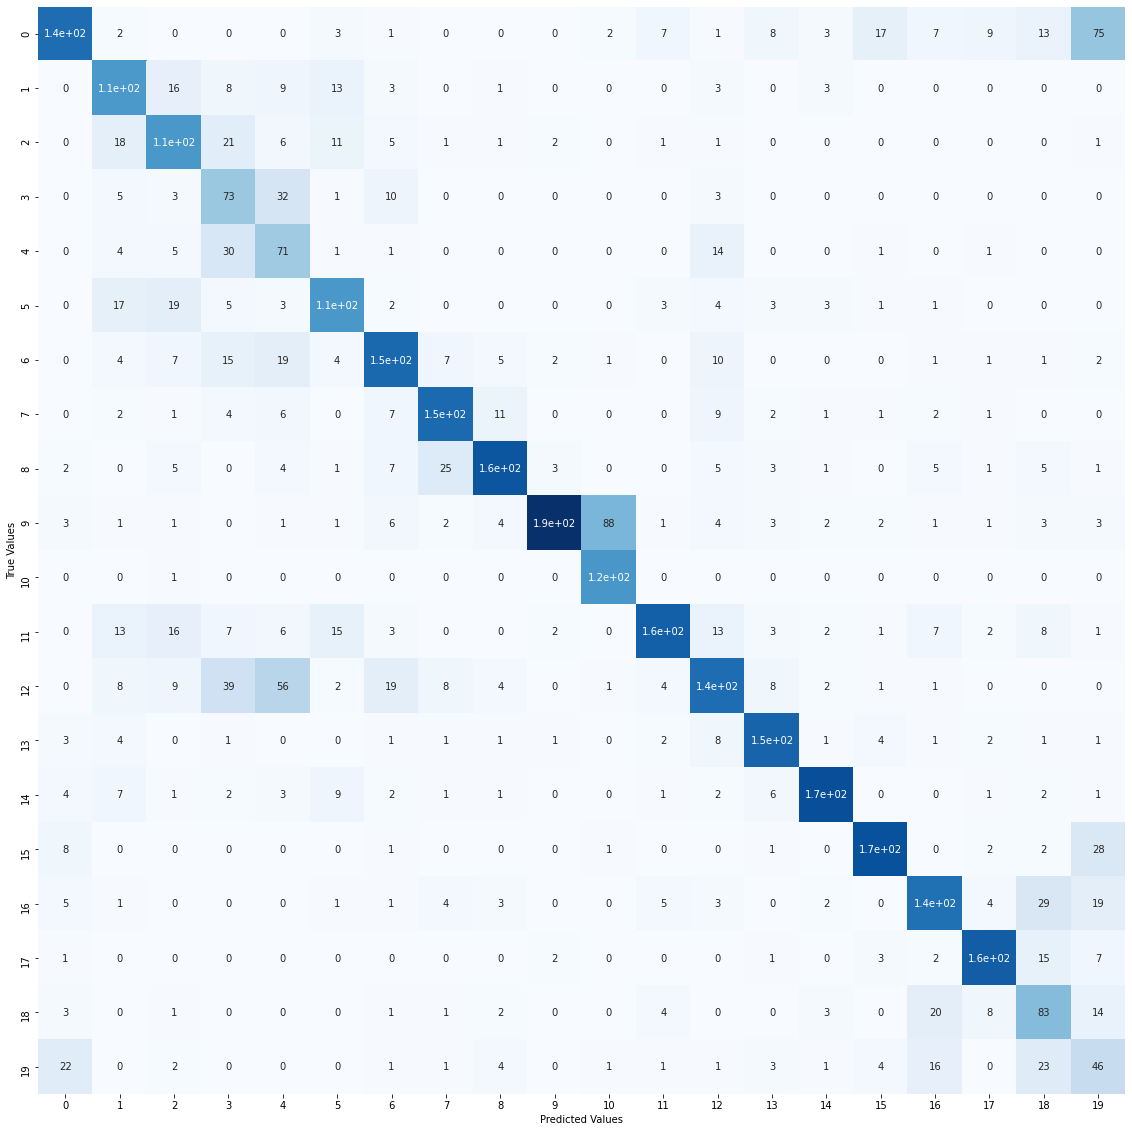

In [31]:
fig = plt.figure(figsize=(20, 20))
y_pred = model.predict(x_val)
Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_val, 1)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

Tabla de rendimientos para la CNN

In [32]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.49      0.74      0.59       196
           2       0.67      0.57      0.61       199
           3       0.63      0.57      0.60       201
           4       0.57      0.36      0.44       205
           5       0.55      0.33      0.41       216
           6       0.65      0.65      0.65       176
           7       0.65      0.68      0.67       220
           8       0.76      0.74      0.75       199
           9       0.70      0.81      0.76       199
          10       0.60      0.94      0.73       202
          11       0.99      0.55      0.71       209
          12       0.61      0.84      0.71       184
          13       0.47      0.64      0.54       226
          14       0.83      0.79      0.81       193
          15       0.80      0.88      0.83       192
          16       0.79      0.83      0.81       201
          17       0.65      0.69      0.67       207
          18       0.84    

Red LSTM

In [33]:
# LSTM
lstm_output_size = 100

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(lstm_output_size)(embedded_sequences)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [34]:
# Training
batch_size = 100
epochs = 3

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

score, acc = model.evaluate(x_val, y_val, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/3
160/160 [==============================] - 216s 1s/step - loss: 2.6249 - acc: 0.1638 - val_loss: 2.4627 - val_acc: 0.2133
Epoch 2/3
160/160 [==============================] - 215s 1s/step - loss: 2.1281 - acc: 0.2923 - val_loss: 2.0217 - val_acc: 0.3171
Epoch 3/3
40/40 [==============================] - 16s 397ms/step - loss: 1.4865 - acc: 0.4771
Test score: 1.4864755868911743
Test accuracy: 0.4771192669868469


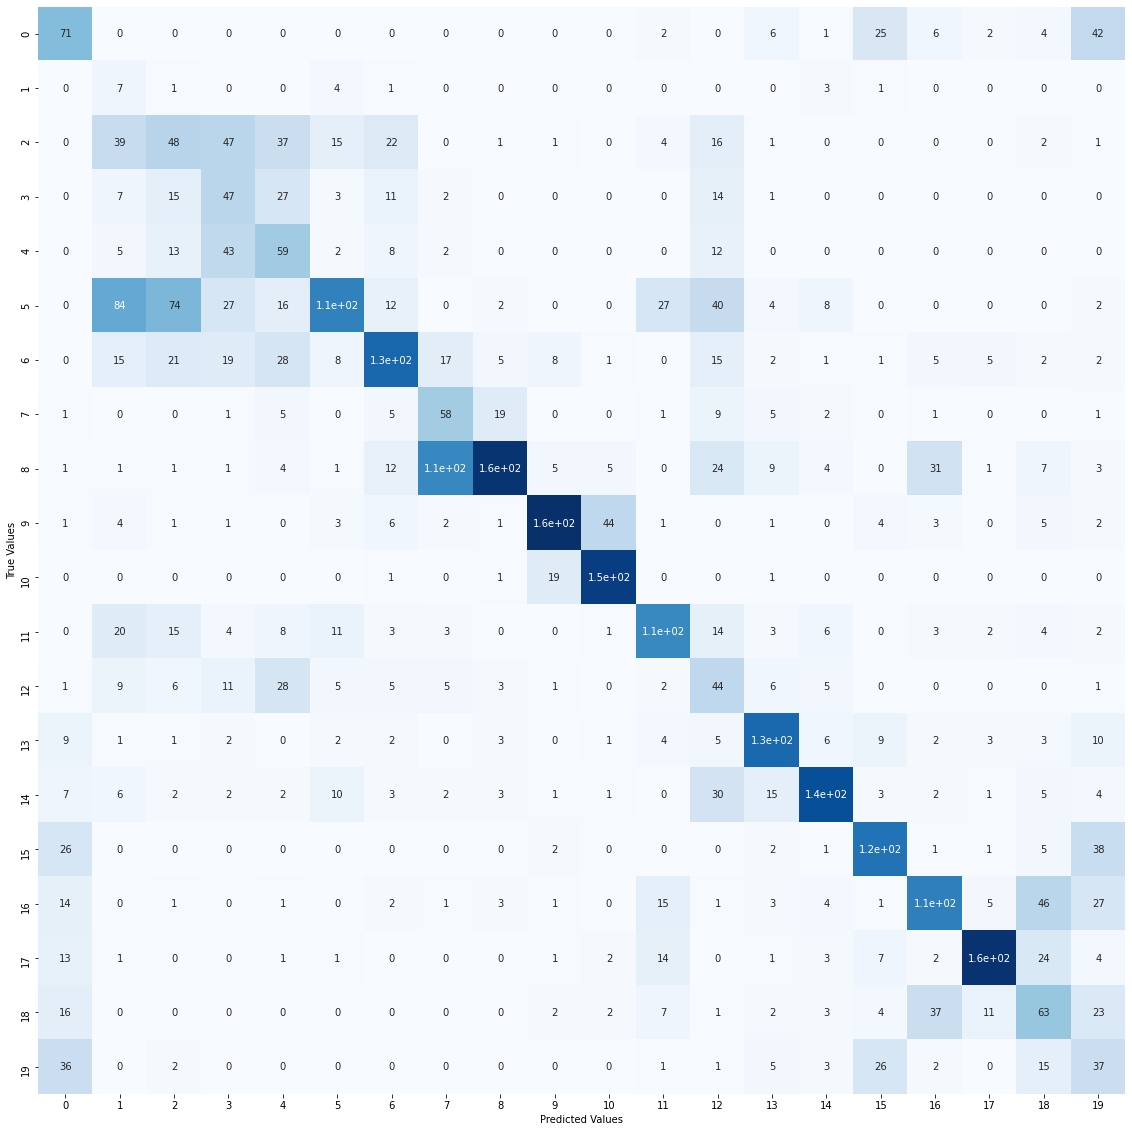

In [35]:
fig = plt.figure(figsize=(20, 20))
y_pred = model.predict(x_val)
Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_val, 1)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [36]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.45      0.36      0.40       196
           2       0.41      0.04      0.06       199
           3       0.21      0.24      0.22       201
           4       0.37      0.23      0.28       205
           5       0.41      0.27      0.33       216
           6       0.27      0.63      0.38       176
           7       0.45      0.58      0.51       220
           8       0.54      0.29      0.38       199
           9       0.42      0.79      0.55       199
          10       0.67      0.80      0.73       202
          11       0.87      0.73      0.79       209
          12       0.52      0.58      0.54       184
          13       0.33      0.19      0.25       226
          14       0.67      0.65      0.66       193
          15       0.59      0.74      0.66       192
          16       0.61      0.60      0.60       201
          17       0.47      0.54      0.50       207
          18       0.68    

## datasets sinteticos



Link: https://keras.io/api/datasets/imdb/

Sentiment Analisys with CNN

In [37]:
# Embedding
max_features = 25000
parcial_len = 80
maxlen = 100
difference = maxlen - parcial_len
embedding_size = 128


# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

Generación de Sustantivos

In [38]:
brown_news_tagged = brown.tagged_words(categories='news')
#tag_fd = nltk.FreqDist(tag for (word, tag) in brown_news_tagged)
#tag_fd.keys()
lista_sustantivos = []
i = 1000 # Se crea una lista de 1000 sustantivos
for (word, tag) in brown_news_tagged:
  if tag == 'NN' and i > 0:
    lista_sustantivos.append(word.lower())
    i = i - 1

print(lista_sustantivos)
print(len(lista_sustantivos))

['investigation', 'primary', 'election', 'evidence', 'place', 'jury', 'term-end', 'charge', 'election', 'praise', 'manner', 'election', 'term', 'jury', 'primary', 'handful', 'jury', 'interest', 'election', 'number', 'size', 'city', 'jury', 'registration', 'election', 'end', 'jury', 'number', 'interest', 'jury', 'efficiency', 'cost', 'administration', 'jury', 'result', 'city', 'city', 'problem', 'implementation', 'automobile', 'title', 'law', 'jury', 'date', 'implementation', 'law', 'jury', 'swipe', 'handling', 'child', 'welfare', 'assistance', 'program', 'jury', 'welfare', 'state', 'exception', 'money', 'distribution', 'program', 'future', 'portion', 'failure', 'burden', 'jury', 'court', 'fire', 'appointment', 'awarding', 'compensation', 'jury', 'court', 'interim', 'committee', 'fact', 'effect', 'jury', 'airport', 'jury', 'management', 'charge', 'airport', 'manner', 'jury', 'surveillance', 'purpose', 'jury', 'doctor', 'intern', 'extern', 'night', 'weekend', 'duty', 'jail', 'city', 'leg

In [39]:
word_to_id = imdb.get_word_index()

INDEX_FROM=3   # word index offset

word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
#print(' '.join(id_to_word[id] for id in train_x[0] ))


id_lista_sustantivos = []

for word in lista_sustantivos:
  try:
    id_lista_sustantivos.append(word_to_id[word])
  except KeyError:
    continue


len(id_lista_sustantivos)

966

In [40]:
'''
Note:
batch_size is highly sensitive.
Only 2 epochs are needed as the dataset is very small.
'''

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [41]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [42]:
print(x_test[0])

[1, 591, 202, 14, 31, 6, 717, 10, 10, 18142, 10698, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 15387, 38, 32, 25, 7944, 451, 202, 14, 6, 717]


In [43]:
#Calculo del promedio
suma = 0
for i in range(25000):
  suma = len(x_train[i]) + suma
print("El promedio de palabras para data_train",suma/25000)

suma = 0
for i in range(25000):
  suma = len(x_test[i]) + suma
print("El promedio de palabras para data_test",suma/25000)

#average = sum(len(word) for word in words) / len(words)

El promedio de palabras para data_train 238.71364
El promedio de palabras para data_test 230.8042


In [44]:
def agregar_palabras_random(dataset, lista_palabras_random, cant_palabras):
  length = len(lista_palabras_random)
  for j in range(len(dataset)):
    if len(dataset[j]) < 5:
        continue
    for i in range(cant_palabras-10):
      rand_index = randint(2, len(dataset[j])-5)
      rand_sust = randint(0, length-1)
      dataset[j].insert(rand_index, lista_palabras_random[rand_sust])
  return dataset

In [45]:
s = " "

lista1 = []

oracion = x_train[0]
for i in oracion:
  lista1.append(id_to_word[i])

print(s.join(lista1))
#print(x_train[0])

i=0

x_train = agregar_palabras_random(x_train, id_lista_sustantivos, difference)
x_test = agregar_palabras_random(x_test, id_lista_sustantivos, difference)


lista2 = []
oracion = x_train[0]
for i in oracion:
  lista2.append(id_to_word[i])

print(s.join(lista2))
#print(x_train[0])


<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

In [46]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


modelo CNN

In [47]:
print('Build CNN model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Flatten())
#model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build CNN model...


In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 128)          3200000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1537      
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [49]:
print('Train CNN model...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train CNN model...
Epoch 1/2


InvalidArgumentError:  indices[17,14] = 28426 is not in [0, 25000)
	 [[node sequential_2/embedding_3/embedding_lookup (defined at <ipython-input-49-c6a527ef25d0>:5) ]] [Op:__inference_train_function_32560]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_2/embedding_3/embedding_lookup:
 sequential_2/embedding_3/embedding_lookup/32271 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
train_function


modelo RNN

In [ ]:
print('Build RNN model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
#model.add(Conv1D(filters,
#                 kernel_size,
#                 padding='valid',
#                 activation='relu',
#                 strides=1))
#model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(lstm_output_size,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

#model.add(Dense(1))
#model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
print('Train RNN model...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Parte 2 - Challenge Kaggle

In [ ]:
import random
import glob
import itertools
import re
import gensim
import pickle
import abc

import scipy.sparse as sp

from collections import Counter
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

torch.backends.cudnn.benchmark = True
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [ ]:
main_path = './'

train_labels_path = main_path + 'train_labels.csv'
train_tree_path = main_path + 'train/'
train_source_path = main_path + 'train_source_tweets.txt'

test_tree_path = main_path + 'test/'
sample_labels_path = main_path + 'sample_submission.csv'
test_source_path = main_path + 'test_source_tweets.txt'

In [ ]:
include_errors = False

# Create dataset

In [ ]:
def remove_random(l,n):
    return random.sample(l,int(len(l)*(1-n)))

In [ ]:
def truncate_list(l,to):
    if len(l)>=to:
        return remove_random(l,0.5)[:to+1]
    return l

In [ ]:
def clean_line(text):
    
    text = text.replace("[", "")
    text = text.replace("]", "")
    text = text.replace("'", "")
    text = text.replace("\n", "")
    text = text.strip()
    
    return text

In [ ]:
def read_data(path):
    
    f = lambda t: (1./(max(t, 0) + 1))
    
    data_child_array = []
    time_array = []
    
    root_tweet_id = ''
    
    for line in open(path, "r", encoding = "UTF-8"):
        
        line = clean_line(line)
        line_array = line.split("->")
        
        parent = line_array[0]
        parent_array = parent.split(",")
        parent_user_id = parent_array[0]
        parent_tweet_id = parent_array[1] 
        parent_time_delay = str(float(parent_array[2]))
        
        child = line_array[1]
        child_array = child.split(",")
        child_user_id = child_array[0]
        child_tweet_id = child_array[1] 
        child_time_delay = str(float(child_array[2]))
        
        
        if parent_user_id == "ROOT":
            
            source_claim = {"user_id" : child_user_id, "time_delay" : f(float(child_time_delay)), "tweet_id":child_tweet_id}
            root_user_id = child_user_id
        
        if parent_user_id !=root_user_id and parent_user_id != "ROOT":
            pkg = "%d:%.10f"%(int(parent_user_id),f(float(parent_time_delay)))
            data_child_array.append(pkg)
    
    #drop percent data here
    #data_child_array = remove_random(data_child_array,0.5)
    data_child_array = truncate_list(data_child_array,30)
    data_child_array.append(source_claim["user_id"]+":"+str(source_claim["time_delay"]))
    edges = ' '.join(data_child_array)
    tweet_id = int(source_claim['tweet_id'])
    
    line = "{}\t{}".format(tweet_id,edges)
    
    return line

In [ ]:
trees_train = glob.glob(os.path.join(train_tree_path, "*.txt"))
trees_test = glob.glob(os.path.join(test_tree_path, "*.txt"))

In [ ]:
error_files_train = []
error_files_test = []

f = open("twitter_graph.txt", "w")

for file in trees_train:
    try:
        f.write(read_data(file)+"\n")
    except:
        error_files_train.append(file)
        print(file)

for file in trees_test:
    try:
        f.write(read_data(file)+"\n")
    except:
        error_files_test.append(file)
        print(file)

f.close()

error_files_train = [int(i.split('/')[-1][:-4]) for i in error_files_train]
error_files_test = [int(i.split('/')[-1][:-4]) for i in error_files_test]

In [ ]:
train_labels = pd.read_csv(train_labels_path)
train_source = pd.read_csv(train_source_path,sep='\t',header=None,names=['id','text'])
train_source['label'] = train_labels['label']
all_source_train = train_source.set_index('id').T.to_dict('list')

In [ ]:
sample_labels = pd.read_csv(sample_labels_path)
test_source = pd.read_csv(test_source_path, sep='\t',header=None,names=['id','text'])
test_source['label'] = sample_labels['label']
all_source_test = test_source.set_index('id').T.to_dict('list')

In [ ]:
if not include_errors:
    for _id in error_files_train:
        del all_source_train[_id]
    for _id in error_files_test:
        del all_source_test[_id]

In [ ]:
from sklearn.model_selection import train_test_split

keys = list(all_source_train.keys())
train_ids, dev_ids = train_test_split(keys, test_size=0.3, random_state=1)

# Preload Dataset

In [ ]:
w2v_dim = 300

dic = {
    'non-rumor': 0,
    'false': 1,
    'unverified': 2,
    'true': 3,
    'sample':4,
}

In [ ]:
def clean_str_cut(string, task=""):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    words = string.strip().lower().split()
    return words

In [ ]:
def build_symmetric_adjacency_matrix(edges, shape):
    def normalize_adj(mx):
        """Row-normalize sparse matrix"""
        rowsum = np.array(mx.sum(1))
        r_inv_sqrt = np.power(rowsum, -0.5).flatten()
        r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
        r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
        return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

    adj = sp.coo_matrix((edges[:, 2], (edges[:, 0], edges[:, 1])), shape=shape, dtype=np.float32)
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj.tocoo()

In [ ]:
X_tids = []
X_uids = []

X_train_tid, X_train_content, y_train = [], [], []
for _id in train_ids:
    text, label = all_source_train[_id]    
    X_tids.append(_id)
    X_train_tid.append(_id)
    X_train_content.append(clean_str_cut(text))
    y_train.append(dic[label])
    
    
X_dev_tid, X_dev_content, y_dev = [], [], []
for _id in dev_ids:
    text, label = all_source_train[_id]
    X_tids.append(_id)
    X_dev_tid.append(_id)
    X_dev_content.append(clean_str_cut(text))
    y_dev.append(dic[label]) 
    

X_test_tid, X_test_content, y_test = [], [], []
for _id in list(all_source_test.keys()):
    text, label = all_source_test[_id]
    X_tids.append(_id)
    X_test_tid.append(_id)
    X_test_content.append(clean_str_cut(text))
    y_test.append(dic[label])


with open("twitter_graph.txt", 'r', encoding='utf-8') as input:
    relation = []
    for line in input.readlines():
        tmp = line.strip().split()
        src = tmp[0]
        X_uids.append(src)

        for dst_ids_ws in tmp[1:]:
            dst, w = dst_ids_ws.split(":")
            X_uids.append(dst)
            relation.append([src, dst, w])    
    
X_id = list(set(X_tids + X_uids))
num_node = len(X_id)
print(num_node)
X_id_dic = {id:i for i, id in enumerate(X_id)}

relation = np.array([[X_id_dic[tup[0]], X_id_dic[tup[1]], tup[2]] for tup in relation])
relation = build_symmetric_adjacency_matrix(relation, shape=(num_node, num_node))

X_train_tid = np.array([X_id_dic[tid] for tid in X_train_tid])
X_dev_tid = np.array([X_id_dic[tid] for tid in X_dev_tid])
X_test_tid = np.array([X_id_dic[tid] for tid in X_test_tid])

In [ ]:
def vocab_to_word2vec(fname, vocab):
    """
    Load word2vec from Mikolov
    """
    word_vecs = {}
    model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)
    count_missing = 0
    for word in vocab:
        if model.__contains__(word):
            word_vecs[word] = model[word]
        else:
            #add unknown words by generating random word vectors
            count_missing += 1
            word_vecs[word] = np.random.uniform(-0.25, 0.25, w2v_dim)

    print(str(len(word_vecs) - count_missing)+" words found in word2vec.")
    print(str(count_missing)+" words not found, generated by random.")
    return word_vecs

In [ ]:
def build_vocab_word2vec(sentences, w2v_path='numberbatch-en.txt'):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    vocabulary_inv = []
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv += [x[0] for x in word_counts.most_common() if x[1] >= 2]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}

    print("embedding_weights generation.......")
    word2vec = vocab_to_word2vec(w2v_path, vocabulary)     #
    embedding_weights = build_word_embedding_weights(word2vec, vocabulary_inv)
    return vocabulary, embedding_weights

In [ ]:
def pad_sequence(X, max_len=50):
    X_pad = []
    for doc in X:
        if len(doc) >= max_len:
            doc = doc[:max_len]
        else:
            doc = [0] * (max_len - len(doc)) + doc
        X_pad.append(doc)
    return X_pad

In [ ]:
def build_word_embedding_weights(word_vecs, vocabulary_inv):
    """
    Get the word embedding matrix, of size(vocabulary_size, word_vector_size)
    ith row is the embedding of ith word in vocabulary
    """
    vocab_size = len(vocabulary_inv)
    embedding_weights = np.zeros(shape=(vocab_size+1, w2v_dim), dtype='float32')
    #initialize the first row
    embedding_weights[0] = np.zeros(shape=(w2v_dim,) )

    for idx in range(1, vocab_size):
        embedding_weights[idx] = word_vecs[vocabulary_inv[idx]]
    print("Embedding matrix of size "+str(np.shape(embedding_weights)))
    return embedding_weights

In [ ]:
def build_input_data(X, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = [[vocabulary[word] for word in sentence if word in vocabulary] for sentence in X]
    x = pad_sequence(x)
    return x

In [ ]:
def w2v_feature_extract(root_path, filename, w2v_path='twitter_w2v.bin'):
    """X_train_tid, X_train, y_train, \
    X_dev_tid, X_dev, y_dev, \
    X_test_tid, X_test, y_test, relation = read_corpus(root_path, filename)"""

    print("text word2vec generation.......")
    vocabulary, word_embeddings = build_vocab_word2vec(X_train + X_dev + X_test, w2v_path=w2v_path)
    pickle.dump(vocabulary, open(root_path + "/vocab.pkl", 'wb'))
    print("Vocabulary size: "+str(len(vocabulary)))

    print("build input data.......")
    X_train = build_input_data(X_train, vocabulary)
    X_dev = build_input_data(X_dev, vocabulary)
    X_test = build_input_data(X_test, vocabulary)

    pickle.dump([X_train_tid, X_train, y_train, word_embeddings, relation], open(root_path+"/train.pkl", 'wb') )
    pickle.dump([X_dev_tid, X_dev, y_dev], open(root_path+"/dev.pkl", 'wb') )
    pickle.dump([X_test_tid, X_test, y_test], open(root_path+"/test.pkl", 'wb') )

In [ ]:
X_train_tid, X_train, y_train, \
X_dev_tid, X_dev, y_dev, \
X_test_tid, X_test, y_test, relation = X_train_tid, X_train_content, y_train, \
X_dev_tid, X_dev_content, y_dev, \
X_test_tid, X_test_content, y_test, \
relation

In [ ]:
print("text word2vec generation.......")
vocabulary, word_embeddings = build_vocab_word2vec(X_train + X_dev + X_test, w2v_path='twitter_w2v.bin')
pickle.dump(vocabulary, open("./vocab.pkl", 'wb'))
print("Vocabulary size: "+str(len(vocabulary)))

print("build input data.......")
X_train = build_input_data(X_train, vocabulary)
X_dev = build_input_data(X_dev, vocabulary)
X_test = build_input_data(X_test, vocabulary)

pickle.dump([X_train_tid, X_train, y_train, word_embeddings, relation], open("./train.pkl", 'wb') )
pickle.dump([X_dev_tid, X_dev, y_dev], open("./dev.pkl", 'wb') )
pickle.dump([X_test_tid, X_test, y_test], open("./test.pkl", 'wb') )

# Creando la red

## GAT

In [ ]:
class SpecialSpmmFunction(torch.autograd.Function):
    """
    Special function for only sparse region backpropataion layer.
    """
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]

        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


In [ ]:
class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

In [ ]:
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data)

        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()


    def forward(self, input, adj):
        N = input.size()[0]
        edge = torch.LongTensor(adj.nonzero())

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        #e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N, 1)).cuda())
        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N, 1)))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out

        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [ ]:
class GAT(nn.Module):

    def __init__(self, nfeat, uV, adj, hidden=16, nb_heads=8, n_output=300, dropout=0.2, alpha=0.3):
        """Sparse version of GAT."""
        super(GAT, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.uV = uV
        self.adj = adj
        self.user_tweet_embedding = nn.Embedding(self.uV, 300, padding_idx=0)
        init.xavier_uniform_(self.user_tweet_embedding.weight)

        self.attentions = nn.ModuleList([SpGraphAttentionLayer(in_features = nfeat,
                                                        out_features= hidden,
                                                        dropout=dropout,
                                                        alpha=alpha,
                                                        concat=True) for _ in range(nb_heads)])
        
        self.out_att = SpGraphAttentionLayer(hidden * nb_heads,
                                              n_output,
                                             dropout=dropout,
                                             alpha=alpha,
                                             concat=False)

    def forward(self, X_tid):
        #X = self.user_tweet_embedding(torch.arange(0, self.uV).long().cuda())
        X = self.user_tweet_embedding(torch.arange(0, self.uV).long())
        X = self.dropout(X)

        X = torch.cat([att(X, self.adj) for att in self.attentions], dim=1)
        X = self.dropout(X)

        X = F.elu(self.out_att(X, self.adj))
        X_ = X[X_tid]
        return X_

## TransformerBlock

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, input_size, d_k=16, d_v=16, n_heads=8, is_layer_norm=False, attn_dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.n_heads = n_heads
        self.d_k = d_k if d_k is not None else input_size
        self.d_v = d_v if d_v is not None else input_size

        self.is_layer_norm = is_layer_norm
        if is_layer_norm:
            self.layer_morm = nn.LayerNorm(normalized_shape=input_size)

        self.W_q = nn.Parameter(torch.Tensor(input_size, n_heads * d_k))
        self.W_k = nn.Parameter(torch.Tensor(input_size, n_heads * d_k))
        self.W_v = nn.Parameter(torch.Tensor(input_size, n_heads * d_v))

        self.W_o = nn.Parameter(torch.Tensor(d_v*n_heads, input_size))
        self.linear1 = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)

        self.dropout = nn.Dropout(attn_dropout)
        self.__init_weights__()
        print(self)

    def __init_weights__(self):
        init.xavier_normal_(self.W_q)
        init.xavier_normal_(self.W_k)
        init.xavier_normal_(self.W_v)
        init.xavier_normal_(self.W_o)

        init.xavier_normal_(self.linear1.weight)
        init.xavier_normal_(self.linear2.weight)

    def FFN(self, X):
        output = self.linear2(F.relu(self.linear1(X)))
        output = self.dropout(output)
        return output

    def scaled_dot_product_attention(self, Q, K, V, episilon=1e-6):
        '''
        :param Q: (*, max_q_words, n_heads, input_size)
        :param K: (*, max_k_words, n_heads, input_size)
        :param V: (*, max_v_words, n_heads, input_size)
        :param episilon:
        :return:
        '''
        temperature = self.d_k ** 0.5
        Q_K = torch.einsum("bqd,bkd->bqk", Q, K) / (temperature + episilon)
        Q_K_score = F.softmax(Q_K, dim=-1)  # (batch_size, max_q_words, max_k_words)
        Q_K_score = self.dropout(Q_K_score)

        V_att = Q_K_score.bmm(V)  # (*, max_q_words, input_size)
        return V_att


    def multi_head_attention(self, Q, K, V):
        bsz, q_len, _ = Q.size()
        bsz, k_len, _ = K.size()
        bsz, v_len, _ = V.size()

        Q_ = Q.matmul(self.W_q).view(bsz, q_len, self.n_heads, self.d_k)
        K_ = K.matmul(self.W_k).view(bsz, k_len, self.n_heads, self.d_k)
        V_ = V.matmul(self.W_v).view(bsz, v_len, self.n_heads, self.d_v)

        Q_ = Q_.permute(0, 2, 1, 3).contiguous().view(bsz*self.n_heads, q_len, self.d_k)
        K_ = K_.permute(0, 2, 1, 3).contiguous().view(bsz*self.n_heads, q_len, self.d_k)
        V_ = V_.permute(0, 2, 1, 3).contiguous().view(bsz*self.n_heads, q_len, self.d_v)

        V_att = self.scaled_dot_product_attention(Q_, K_, V_)
        V_att = V_att.view(bsz, self.n_heads, q_len, self.d_v)
        V_att = V_att.permute(0, 2, 1, 3).contiguous().view(bsz, q_len, self.n_heads*self.d_v)

        output = self.dropout(V_att.matmul(self.W_o)) # (batch_size, max_q_words, input_size)
        return output


    def forward(self, Q, K, V):
        '''
        :param Q: (batch_size, max_q_words, input_size)
        :param K: (batch_size, max_k_words, input_size)
        :param V: (batch_size, max_v_words, input_size)
        :return:  output: (batch_size, max_q_words, input_size)  same size as Q
        '''
        V_att = self.multi_head_attention(Q, K, V)

        if self.is_layer_norm:
            X = self.layer_morm(Q + V_att)  # (batch_size, max_r_words, embedding_dim)
            output = self.layer_morm(self.FFN(X) + X)
        else:
            X = Q + V_att
            output = self.FFN(X) + X
        return output

# NeuralNetwork

In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.best_acc = 0
        self.patience = 0
        self.init_clip_max_norm = None
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    @abc.abstractmethod
    def forward(self):
        pass

    def fit(self, X_train_tid, X_train, y_train,
                  X_dev_tid, X_dev, y_dev):

        if torch.cuda.is_available():
            self.cuda()
        batch_size = self.config['batch_size']
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        X_train_tid = torch.LongTensor(X_train_tid)
        X_train = torch.LongTensor(X_train)
        y_train = torch.LongTensor(y_train)

        dataset = TensorDataset(X_train_tid, X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        loss_func = nn.CrossEntropyLoss()
        for epoch in range(self.config['epochs']):
            print("\nEpoch ", epoch+1, "/", self.config['epochs'])
            self.train()
            avg_loss = 0
            avg_acc = 0
            for i, data in enumerate(dataloader):
                with torch.no_grad():
                    #batch_x_tid, batch_x_text, batch_y = (item.cuda(device=self.device) for item in data)
                    batch_x_tid, batch_x_text, batch_y = (item.to(self.device) for item in data)

                self.optimizer.zero_grad()
                logit = self.forward(batch_x_tid, batch_x_text)
                loss = loss_func(logit, batch_y)
                loss.backward()
                self.optimizer.step()

                corrects = (torch.max(logit, 1)[1].view(batch_y.size()).data == batch_y.data).sum()
                accuracy = 100*corrects/len(batch_y)

                print('Batch[{}] - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(i, loss.item(), accuracy, corrects, batch_y.size(0)))
                if i > 0 and i % 100 == 0:
                    self.evaluate(X_dev, y_dev)
                    self.train()

                avg_loss += loss.item()
                avg_acc += accuracy

                if self.init_clip_max_norm is not None:
                    utils.clip_grad_norm_(self.parameters(), max_norm=self.init_clip_max_norm)

            cnt = y_train.size(0) // batch_size + 1
            print("Average loss:{:.6f} average acc:{:.6f}%".format(avg_loss/cnt, avg_acc/cnt))
            if epoch >= 10 and self.patience > 3:
                print("Reload the best model...")
                self.load_state_dict(torch.load(self.config['save_path']))
                now_lr = self.adjust_learning_rate(self.optimizer)
                print(now_lr)
                self.patience = 0

            self.evaluate(X_dev_tid, X_dev, y_dev)


    def adjust_learning_rate(self, optimizer, decay_rate=.5):
        now_lr = 0
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * decay_rate
            now_lr = param_group['lr']
        return now_lr


    def evaluate(self, X_dev_tid, X_dev, y_dev):
        y_pred = self.predict(X_dev_tid, X_dev)
        acc = accuracy_score(y_dev, y_pred)

        if acc > self.best_acc:
            self.best_acc = acc
            self.patience = 0
            torch.save(self.state_dict(), self.config['save_path'])
            print(classification_report(y_dev, y_pred, target_names=self.config['target_names'], digits=5))
            print("Val set acc:", acc)
            print("Best val set acc:", self.best_acc)
            print("save model!!!")
        else:
            self.patience += 1


    def predict(self, X_test_tid, X_test):
        if torch.cuda.is_available():
            self.cuda()

        self.eval()
        y_pred = []
        #X_test_tid = torch.LongTensor(X_test_tid).cuda()
        X_test_tid = torch.LongTensor(X_test_tid)
        #X_test = torch.LongTensor(X_test).cuda()
        X_test = torch.LongTensor(X_test)

        dataset = TensorDataset(X_test_tid, X_test)
        dataloader = DataLoader(dataset, batch_size=50)

        for i, data in enumerate(dataloader):
            with torch.no_grad():
                #batch_x_tid, batch_x_text = (item.cuda(device=self.device) for item in data)
                batch_x_tid, batch_x_text = (item.to(self.device) for item in data)

            logits = self.forward(batch_x_tid, batch_x_text)
            predicted = torch.max(logits, dim=1)[1]
            y_pred += predicted.data.cpu().numpy().tolist()
        return y_pred

# GLAN

In [ ]:
class GLAN(NeuralNetwork):

    def __init__(self, config, adj):
        super(GLAN, self).__init__()
        self.config = config
        self.uV = adj.shape[0]
        embedding_weights = config['embedding_weights']
        V, D = embedding_weights.shape
        maxlen = config['maxlen']
        dropout_rate = config['dropout']

        self.mh_attention = TransformerBlock(input_size=300)
        self.word_embedding = nn.Embedding(V, D, padding_idx=0, _weight=torch.from_numpy(embedding_weights))

        self.relation_embedding = GAT(nfeat=300, uV=self.uV, adj=adj)

        self.convs = nn.ModuleList([nn.Conv1d(300, 100, kernel_size=K) for K in config['kernel_sizes']])
        self.max_poolings = nn.ModuleList([nn.MaxPool1d(kernel_size=maxlen - K + 1) for K in config['kernel_sizes']])

        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(600, 300)
        self.fc2 = nn.Linear(300, config['num_classes'])

        self.init_weight()
        print(self)

    def init_weight(self):
        init.xavier_normal_(self.fc1.weight)
        init.xavier_normal_(self.fc2.weight)


    def forward(self, X_tid, X_text):
        X_text = self.word_embedding(X_text) # (N*C, W, D)
        X_text = self.mh_attention(X_text, X_text, X_text)
        X_text = X_text.permute(0, 2, 1)

        rembedding = self.relation_embedding(X_tid)

        conv_block = [rembedding]
        for _, (Conv, max_pooling) in enumerate(zip(self.convs, self.max_poolings)):
            act = self.relu(Conv(X_text))
            pool = max_pooling(act)
            pool = torch.squeeze(pool)
            conv_block.append(pool)
        conv_feature = torch.cat(conv_block, dim=1)
        features = self.dropout(conv_feature)

        a1 = self.relu(self.fc1(features))
        d1 = self.dropout(a1)

        output = self.fc2(d1)
        return output

# RUN

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
config = {
    'reg':0,
    'batch_size':64,
    'nb_filters':100,
    'kernel_sizes':[3, 4, 5],
    'dropout':0.3,
    'maxlen':50,
    'epochs':10,
    'num_classes':4,
    'target_names':['NR', 'FR', 'UR', 'TR']
}

In [ ]:
X_train_tid, X_train, y_train, word_embeddings, adj = X_train_tid, X_train, y_train, word_embeddings, relation

X_dev_tid, X_dev, y_dev = X_dev_tid, X_dev, y_dev

X_test_tid, X_test, y_test = X_test_tid, X_test, y_test

config['embedding_weights'] = word_embeddings

print("#nodes: ", adj.shape[0])

## Run Model

In [ ]:
model_suffix = GLAN.__name__.lower().strip("text")
config['save_path'] = 'checkpoint/weights.best.twitter.'+ model_suffix

mod_nn = GLAN(config, adj)

In [ ]:
!mkdir checkpoint

In [ ]:
mod_nn.fit(X_train_tid, X_train, y_train,X_dev_tid, X_dev, y_dev)

## Make Predicction

In [ ]:
mod_nn.load_state_dict(torch.load(config['save_path']))
y_pred = mod_nn.predict(X_test_tid, X_test)

## Save submission

In [ ]:
dic = {
    0:'non-rumor',   # Non-rumor   NR
    1:'false',   # false rumor    FR
    2:'unverified',  # unverified tweet  UR
    3:'true',    # debunk rumor  TR
}
sample_pred_label = [dic[i] for i in y_pred]

In [ ]:
import pandas as pd
submit = pd.read_csv(sample_labels_path)

if not include_errors:
    for _id in error_files_test:
        indexNames = submit[ submit['id'] == _id ].index
        submit.drop(indexNames , inplace=True)

        sample_ids = submit['id']
        
    final_sub = pd.DataFrame ({'label':sample_pred_label+['unverified']*len(error_files_test),'id':list(sample_ids)+error_files_test }, columns = ['label','id'])
else:
    final_sub = pd.DataFrame ({'label':sample_pred_label,'id':sample_ids }, columns = ['label','id'])


In [ ]:
final_sub.to_csv('./submission_kaggle.csv', index=False, header=True)